# 0. Udacity project - Airbnb Seattle

### Questions to answer
* During which period of the year is items on airbnb in highest demand?
* Is there a higher demand over weekends?
* Does the user behaviour increase demand?
    - Does ratings for cleanliness and communication matter?
    - Do the customers premium high response rates?
    - Do a more comprehensive text description of the item affect demand?
    - What about the user details? Do the data imply that one should focus on a long personal description? 

## 0.1 Import libraries

In [1]:
import pandas as pd
import numpy as np

import os
import glob

import datetime as dt
import holidays

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import statsmodels.api as sm

## 0.2 Functions and plots used in the notebook

### 0.2.1. Plots

In [2]:
# A bar plot which shows the booking rate with in a category variable
def plot_average_rate(df, cat_col, booking_column, color='blue'):
    '''
    Generetes a bar plot showing the average booking rate for the given categorical variable.
    Args:
        df (DataFrame): A DataFrame containing the dataset with the categorical and booking columns.
        cat_col (str): The name of the categorical column used for grouping and plotting on the x-axis.
        booking_column (str): The name of the target column, used to calculate the mean booking rate. Must be binary.
        color (str): The color of the bars in the plot. (Optional: default='blue')
    Returns:
        None
    '''
    # Group data by the categorical column and calculate mean
    plot_data = df.groupby(cat_col, observed=True)[booking_column].mean().reset_index()

    # Set style
    sns.set(style='ticks')

    # Create the bar plot
    plt.figure(figsize=(15, 6))
    bar_plot = sns.barplot(x=cat_col, y=booking_column, data=plot_data, color=color)

    # Add title and labels
    plt.title(f'Booking rate, dependingon the variable {cat_col}')
    plt.ylabel('Average booking rate (1=100% booking rate)')
    plt.xlabel(None)

    # Set limits
    plt.ylim(0, 1)

    # Add value labels on the bars
    for p in bar_plot.patches:
        bar_plot.annotate(f'{p.get_height():.2f}', 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                          ha='center', va='bottom', 
                          fontsize=12, color='black', 
                          xytext=(0, 5),  # 5 points vertical offset
                          textcoords='offset points')

    # Rotate the x-axis labels for better readability
    plt.xticks(rotation=45)

    plt.show()

In [209]:
# A bar plot which shows the booking rate with in a category variable
def plot_average_rate_jan(df, cat_col, booking_column, color='blue'):
    '''
    Generetes a bar plot showing the average booking rate for the given categorical variable.
    - January date
    Args:
        df (DataFrame): A DataFrame containing the dataset with the categorical and booking columns.
        cat_col (str): The name of the categorical column used for grouping and plotting on the x-axis.
        booking_column (str): The name of the target column, used to calculate the mean booking rate. Must be binary.
        color (str): The color of the bars in the plot. (Optional: default='blue')
    Returns:
        None
    '''
    # Group data by the categorical column and calculate mean
    plot_data = df.groupby(cat_col, observed=True)[booking_column].mean().reset_index()

    # Set style
    sns.set(style='ticks')

    # Create the bar plot
    plt.figure(figsize=(15, 6))
    bar_plot = sns.barplot(x=cat_col, y=booking_column, data=plot_data, color=color)

    # Add title and labels
    plt.title(f'Booking rate, dependingon the variable {cat_col} - January result')
    plt.ylabel('Average booking rate (1=100% booking rate)')
    plt.xlabel(None)

    # Set limits
    plt.ylim(0, 1)

    # Add value labels on the bars
    for p in bar_plot.patches:
        bar_plot.annotate(f'{p.get_height():.2f}', 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                          ha='center', va='bottom', 
                          fontsize=12, color='black', 
                          xytext=(0, 5),  # 5 points vertical offset
                          textcoords='offset points')

    # Rotate the x-axis labels for better readability
    plt.xticks(rotation=45)

    plt.show()

In [3]:
def dataset_null_share(df):
    """
     A function which returns the number of columns with miss data and the share of missing values in those columns.
    Args:
        df (DataFrame): The DataFrame for which missing values are analyzed.
    Returns:
        DataFrame: A DataFrame showing columns with missing data and the corresponding share of missing values.
    Prints:
        The number of variables with missing values in the dataset.
    """
    df_null_share=df.isnull().mean().reset_index().rename(columns={0:'Share_null'})

    print('The number of variables with missing data in the dataset are {0} out of {1}'.format(df_null_share.query('Share_null>0')['Share_null'].count(), df_null_share['Share_null'].count()))

    return df_null_share.query('Share_null>0')

### 0.2.1. Categorization functions

In [4]:
# Define a function to help us add dummies to the datafram
def get_dummy_cats(df, variable, prefix=None):
    '''Function adding the dummies for a defined variable to a dataframe, 
    while also dropping the dummy in alphabeticall order
    Args:
        df (DataFrame): a dataframe containing the dataset from which the dummies will be genereated and returned to
        variable (str): the column containing the categorical variable from which the dummies will be extracted
        prefix (str): If desired, a prefix can be set to each variable, followed by a "_". (Optional: default=None)
    Returns:
        df (DataFrame): a dataframe containing the generated dummy variable.
    '''
    df_temp=pd.get_dummies(df[variable], drop_first=True, prefix=prefix).astype('int')
    
    df=pd.concat([df, df_temp], axis=1)

    return df

### 0.2.3 Modeling functions

In [5]:
# In this case I have modified the function provided in excercise "2.40 Excercise solutions: Categorical variables", in order to test how well my model predicts the probability of having the airbnb item rented out.
## I have removed the model-building part of the function, and updated the LinearRegression() section as this is outdated in current python-packages and normalization is not necessary when only working with binary values.

def clean_fit_linear_mod(df, response_col, cat_cols, test_size=.3, rand_state=42):
    '''
    A function which tests the predictability of an OLS model on a set of 

    Args:
        df(DataFrame) - a dataframe holding all the variables of interest
        response_col (str): A string holding the name of the column
        cat_cols (list): a list of explanatory variables used to predict the outcome of the response column
        test_size (floatr): A float between [0,1] about what proportion of data should be in the test dataset
        rand_state (int): An int that is provided as the random state for splitting the data into training and test 
    
    Return:
        test_score (float): r2 score on the test data
        train_score (float): r2 score on the train data

    '''

    #Split into explanatory and response variables
    X = df.drop(response_col, axis=1)
    y = df[response_col]

    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rand_state)

    # Using Linear Regression without normalization (since we're working with binary data)
    lm_model = LinearRegression()
    lm_model.fit(X_train, y_train)  # Fit the model


    #Predict using your model
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)

    #Score using your model
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)

    return test_score, train_score

In [6]:
def ols_summary(df, response_col, cat_cols):
    '''
    Function returning a results summary for a OLS model, based on a set of y (resonse_col) and X (cat_cols) variables.
    The function only aims at excamining individual predictors, not predictability of the model as a whole, why training and testing will not be implemented
    
    Args:
        df(DataFrame) - a dataframe holding all the variables of interest
        response_col (str): A string holding the name of the column
        cat_cols (list): a list of explanatory variables used to predict the outcome of the response column

    returns:
        Summary: a summary table of the model
        '''
    # Define the feature matrix X and the target vector y
    X = df[cat_cols]  # Features
    y = df[response_col]  # Target
    
    # Add a constant to the feature matrix (for the intercept)
    X = sm.add_constant(X)
    
    # Fit the OLS model using statsmodels
    ols_model = sm.OLS(y, X).fit()
    
    # Print the summary of the model
    summary = ols_model.summary()
    
    return summary

In [7]:
# Test the logit model using stasmodel logit, to account for the fact that we are using a model with a binary explanatory variable
## further documentation on package used can be found here: https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.Logit.html
### Further reading regarding logistic regressions can be found here: https://www.ibm.com/topics/logistic-regression

def logit_marginal_effects(df, response_col, cat_cols):
    '''
    Args:
        df(DataFrame) - a dataframe holding all the variables of interest
        response_col (str): A string holding the name of the column
        cat_cols (list): a list of explanatory variables used to predict the outcome of the response column

    returns:
        Summary: a summary table of the model
        marginal_effects: A summary table containging the marginal effects of coefficients
    '''
    
    X = df[cat_cols] 
    y = df[response_col]  
        
    logit_model = sm.Logit(y, X).fit()
    
    # Get the summary of the model
    summary = logit_model.summary()
    
    # Calculate the marginal effects
    marginal_effects = logit_model.get_margeff()
    
    return summary, marginal_effects.summary()

For project definition and thesis, see readme file in project readme.

# 1. Data understanding/Data preperation/data cleaning

## - CRISP-DM steps 2-3

In [8]:
# Define survey path
## Data downloaded from https://www.kaggle.com/datasets/airbnb/seattle/data
data_path='./airbnb_data/'

## 1.1 Data handling: data source "Calendar"

In [9]:
# Import calender data
df_calender = pd.read_csv(os.path.join(data_path, "calendar.csv"))

# Investigate data using Data Wrangler

In [10]:
# view data
df_calender.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


We will be using all columns in the calender dataset, except price since this will be made available in the listings dataset. The columns we will use are:
- listing_id: id of the object being rented out
- date: the date of the data row
- available: t=the object is available, f= the object is not available

In [11]:
df_calender=df_calender[['listing_id', 'date', 'available']]

### 1.1.1. Overview

In [12]:
# View number of listings
df_calender.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
dtypes: int64(1), object(2)
memory usage: 31.9+ MB


In [13]:
# Check null values
dataset_null_share(df_calender)

The number of variables with missing data in the dataset are 0 out of 3


,index,Share_null


### 1.1.2. Variable: listings_id

In [14]:
# Use describe to view the disribution of the number of days available per listing
ids_days=df_calender.groupby('listing_id').size().reset_index().rename(columns={0:'listing_days'}).sort_values(by='listing_days')
ids_days.describe()

,listing_id,listing_days
count,3.818000e+03,3818.0
mean,5.550111e+06,365.0
std,2.962660e+06,0.0
min,3.335000e+03,365.0
25%,3.258256e+06,365.0
50%,6.118244e+06,365.0
75%,8.035127e+06,365.0
max,1.034016e+07,365.0


The dataset contains 3818 listings, with 365 observations for each listing

### 1.1.3. Variable: date

In [15]:
# What dates are included in the dataset?
print('The data contants {0} dates. This would imply a full year'.format(len(df_calender['date'].unique())))
print('The first date in the set is {} and the last date is {}'.format(df_calender['date'].min(), df_calender['date'].max()))

The data contants 365 dates. This would imply a full year
The first date in the set is 2016-01-04 and the last date is 2017-01-02


In [16]:
# Are there missing data?
print('There are {0} missing data counts '.format(df_calender['date'].isnull().sum()))

There are 0 missing data counts 


#### 1.1.3.1. date - data preparation

In [17]:
# date is currently datatype object. Since it is a date, we want to transform it to such in order to be able to correctly work with the information.
df_calender['date']=pd.to_datetime(df_calender['date'])

In [18]:
df_calender['date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1393570 entries, 0 to 1393569
Series name: date
Non-Null Count    Dtype         
--------------    -----         
1393570 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 10.6 MB


##### 1.1.3.1. Get weekday

In [19]:
# Other than specific date, we will want to use day of the week in our analysis. 
## DateTime weekday return the day as an int, where 0=Monday and 6=Sunday (see: https://docs.python.org/3/library/datetime.html)
df_calender['dayofweek']=df_calender['date'].dt.weekday

In [20]:
# Check result
df_calender.groupby(['date','dayofweek']).size().reset_index().head(10)

,date,dayofweek,0
0,2016-01-04,0,3818
1,2016-01-05,1,3818
2,2016-01-06,2,3818
3,2016-01-07,3,3818
4,2016-01-08,4,3818
5,2016-01-09,5,3818
6,2016-01-10,6,3818
7,2016-01-11,0,3818
8,2016-01-12,1,3818
9,2016-01-13,2,3818


A quick check in the calender shows that the first full week of 2016 did indeed start with jan 4.

In [21]:
# Check result
df_calender.groupby(['date','dayofweek']).size().reset_index().tail(10)

,date,dayofweek,0
355,2016-12-24,5,3818
356,2016-12-25,6,3818
357,2016-12-26,0,3818
358,2016-12-27,1,3818
359,2016-12-28,2,3818
360,2016-12-29,3,3818
361,2016-12-30,4,3818
362,2016-12-31,5,3818
363,2017-01-01,6,3818
364,2017-01-02,0,3818


It also shows that the year did end on a saturday. This also implies that we might want to loose jan 2, since this is a new week and if we want to keep the data set clean this might be excluded.

##### 1.1.3.1. Get weekend, midweek

In [22]:
# Use dayofweek to define weekend (including friday, i.e. dayofweek=4,5,6) and midweek (midweek=0,1,2,3))
## Use df.apply(lambda x:)
## Weekend will be defined as 1, while midweek is defined as 0
df_calender['weekend']=df_calender['dayofweek'].apply(lambda x: 1 if x>3 else 0)


In [23]:
# Check result
df_calender.groupby(['dayofweek','weekend']).size()

dayofweek  weekend
0          0          202354
1          0          198536
2          0          198536
3          0          198536
4          1          198536
5          1          198536
6          1          198536
dtype: int64

##### 1.1.3.1. Get holliday

In [24]:
# Since we are interested in examining occupancy rates we might also be interested in checking for public hollidays.
## This can be done using the library holidays (https://pypi.org/project/holidays/)
us_holidays = holidays.country_holidays('US')

In [25]:
# check each date in our calender to see if it is present in the list of us_holiday
## holliday=1 and not holliday=0
df_calender['holliday']=df_calender['date'].apply(lambda x: x in us_holidays).astype('int')

##### 1.1.3.1. Get month

In [26]:
# We also would like month 
## DateTime weekday return the day as an int, where 1=January and 12=December (see: https://docs.python.org/3/library/datetime.html)
df_calender['month']=df_calender['date'].dt.month

In [27]:
# Check result
df_calender.groupby(['date','month']).size().reset_index().head(10)

,date,month,0
0,2016-01-04,1,3818
1,2016-01-05,1,3818
2,2016-01-06,1,3818
3,2016-01-07,1,3818
4,2016-01-08,1,3818
5,2016-01-09,1,3818
6,2016-01-10,1,3818
7,2016-01-11,1,3818
8,2016-01-12,1,3818
9,2016-01-13,1,3818


### 1.1.4. Variable: available

In [28]:
# Contains information on wether or not the listing is available for renting. It contains no missing data
df_calender['available'].isnull().sum()

np.int64(0)

In [29]:
# Show content
df_calender['available'].value_counts()

available
t    934542
f    459028
Name: count, dtype: int64

##### 1.1.4.1 available - data preparation (MAIN KPI)

In [30]:
# MAIN KPI
## Since we are interested to know booking rate at the listings, we will change availability to booked
### Instead of using "t" or "f" for available, we create the variable "listing_booked", taking on the value 1 if booked and 0 if not booked.
### Therefore, if an item is unavailable (available==0), we make the assumption that it is booked.
#### NOTE: This is a simplification and a large assumption - further analysis and data clarification would be need for this assumption to be confirmed

df_calender['listing_booked']=df_calender['available'].apply(lambda x: 1 if x=='f' else 0)

In [31]:
# Check result
df_calender.groupby(['listing_booked', 'available']).size()

listing_booked  available
0               t            934542
1               f            459028
dtype: int64

In [32]:
# Drop original column
df_calender.drop(columns='available', inplace=True)

### 1.1.5. KPI: listing_booked  

In [33]:
## Now we can have a quick overview of the data
df_calender.head()

,listing_id,date,dayofweek,weekend,holliday,month,listing_booked
0,241032,2016-01-04,0,0,0,1,0
1,241032,2016-01-05,1,0,0,1,0
2,241032,2016-01-06,2,0,0,1,1
3,241032,2016-01-07,3,0,0,1,1
4,241032,2016-01-08,4,1,0,1,1


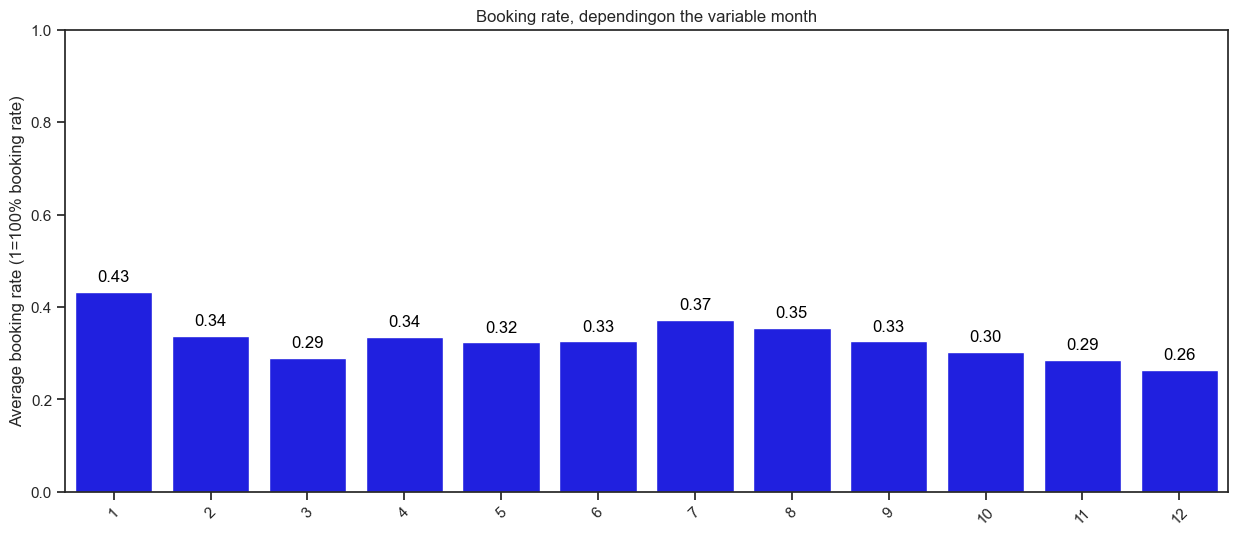

In [34]:
plot_average_rate(df_calender, 'month', 'listing_booked')

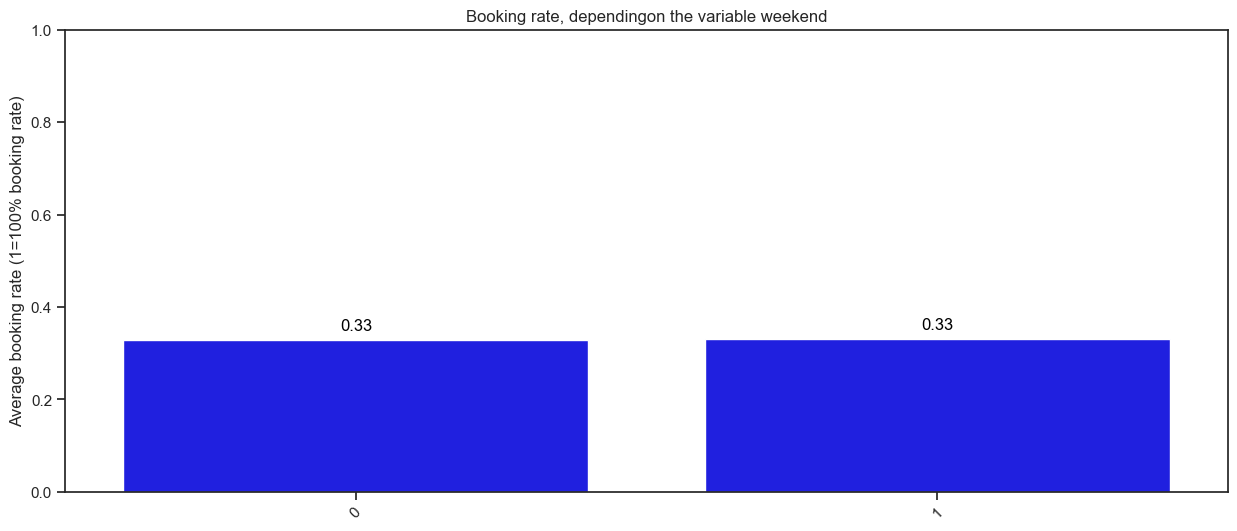

In [35]:
plot_average_rate(df_calender, 'weekend', 'listing_booked')

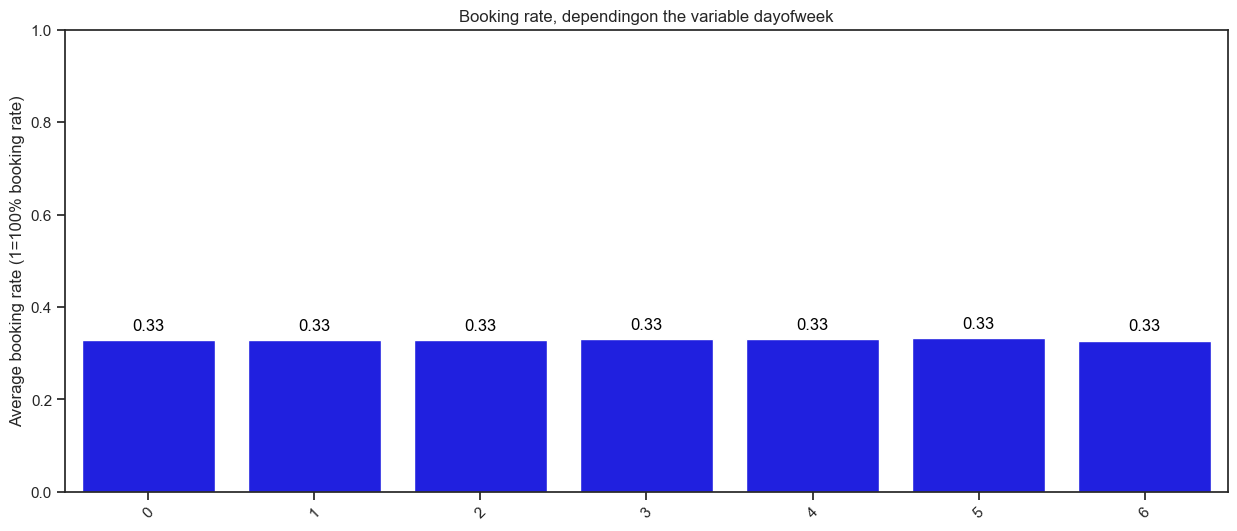

In [36]:
plot_average_rate(df_calender, 'dayofweek', 'listing_booked')

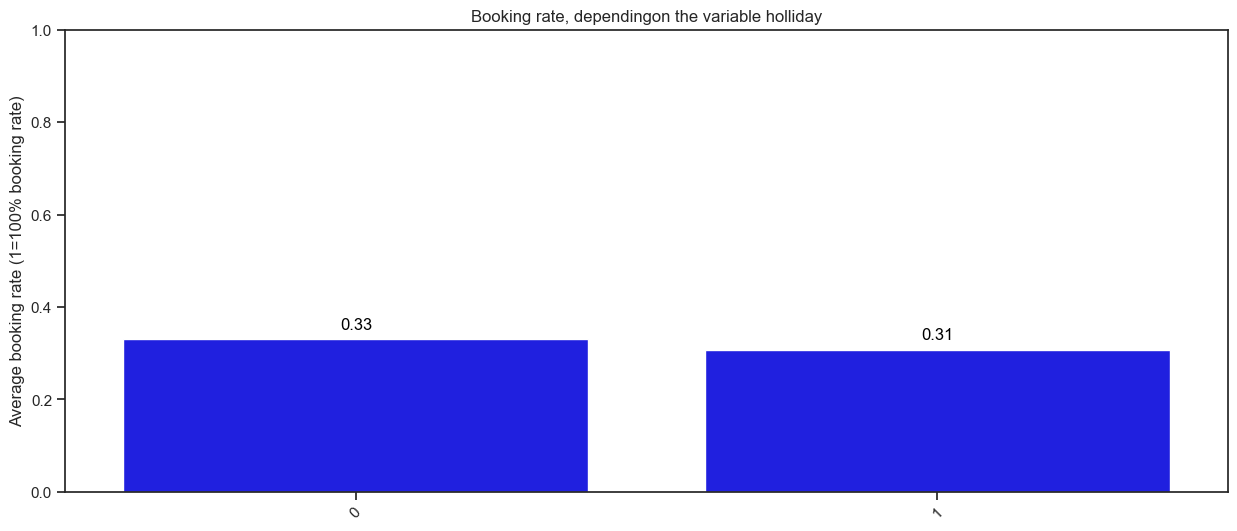

In [37]:
plot_average_rate(df_calender, 'holliday', 'listing_booked')

### ANSER FOR QUESTIONS 1 and QUESTION 2

The data looks reasonable. The nearer dates should be more heavily booked at the beginning of the year than they would be further in advance. We also see that the summer periods (july and august) have already more booked than the rest of the year (january excluded)

Weekends and hollidays does not appear to be more booked then regular days, which may be surprising. However, since the most pre-booked dates seems to be during the summer months this could be that weekends and hollidays are not booked in advance at the same rate as summer hollidays. Since summer hollidays are not defined by weekends or public hollidays, this would explain the result.

In [38]:
# Due to the result above, we will only keep month of the created date variables in going forward.
df_calender=df_calender[['listing_id', 'month', 'listing_booked']]

In [39]:
# We will also get dummy variables for each month, in order to be able to use the variable in a model
df_calender=get_dummy_cats(df_calender, 'month', prefix='month')

"listing_booked" will be our main KPI going forward.

## 1.2. Data handling: Data source "listings"

In [40]:
# Import data
df_listings = pd.read_csv(os.path.join(data_path, "listings.csv"))

# Investigate data using Data Wrangler

In [41]:
# Data to use (having used Data Wrangler to look at the data)
columns_of_interest=['id',
                    'price',
                    'description',
                    'neighbourhood_group_cleansed',
                    'room_type',
                    'property_type',  
                    'accommodates',
                    'review_scores_cleanliness', 
                    'review_scores_communication', 
                    'host_about', 
                    'host_response_time', 
                    'host_response_rate']

In [42]:
# Only keep the columns that we are interested in for the project
df_listings=df_listings[columns_of_interest]

In [43]:
# Check number of columns with missing data, and the share of missing data in those columns
dataset_null_share(df_listings)

The number of variables with missing data in the dataset are 6 out of 12


,index,Share_null
5,property_type,0.000262
7,review_scores_cleanliness,0.171032
8,review_scores_communication,0.170508
9,host_about,0.224987
10,host_response_time,0.136983
11,host_response_rate,0.136983


Most columns that we are interested in have quite a small share of missing values. Those that have, security deposit, host information and review will most likelly be usable anyhow since this may imply a lack of answer or review, which can be interpreted in the model.

Since understanding the effect these variables may have on availability, we will merge the datasets at this stage for futher data preparations.

## 1.3. Data handling: Merge data

In [44]:
# Merge calender data and listings information using listing id's in both data sets
df_airbnb=pd.merge(df_calender, df_listings, left_on='listing_id', right_on='id', how='left')

In [45]:
# Drop 'id', since this is no longer used for modelling
df_airbnb=df_airbnb.drop(columns='id')

### 1.3.0 Missing values

In [46]:
# Check number of columns with missing data, and the share of missing data in those columns
dataset_null_share(df_airbnb)

The number of variables with missing data in the dataset are 6 out of 25


,index,Share_null
18,property_type,0.000262
20,review_scores_cleanliness,0.171032
21,review_scores_communication,0.170508
22,host_about,0.224987
23,host_response_time,0.136983
24,host_response_rate,0.136983


In [47]:
# See total share of missing for any row
df_airbnb.isnull().any(axis=1).mean()

np.float64(0.3795180722891566)

These are the same missing values seen in our listings dataset. The total amount of missing values amount to 38% of the dataset. This is a huge part of our dataset, but since we are interested in how user activites affect the chance of having a high averige booking rate the columns are important.

[np.float64(0.38154041048621157), np.float64(0.32938998399793334)]


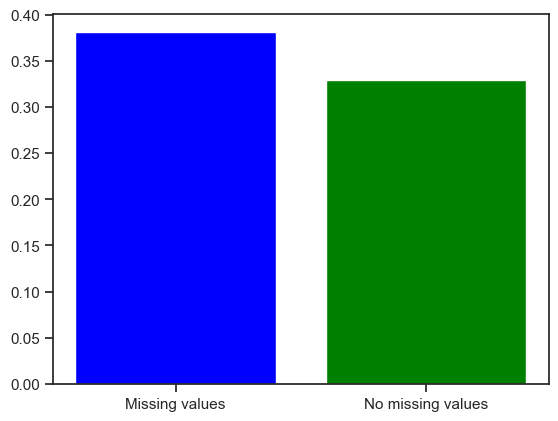

In [48]:
# Lets look at the mean differences in a graph
mean_missing=df_airbnb[df_airbnb.isnull().any(axis=1)]['listing_booked'].mean()
mean_not_missing=df_airbnb[df_airbnb.notnull().any(axis=1)]['listing_booked'].mean()

# Create a bar plot
labels = ['Missing values', 'No missing values']
mean_booking = [mean_missing, mean_not_missing]

plt.bar(labels, mean_booking, color=['blue', 'green']);

print(mean_booking)

There is also a fairly large difference in mean value between the rows contaning nulls and the rows which do not.

THIS MAY POINT TO A FLAW IN OUR ASSUMPTION. What missing values could imply is that the user is very inactive, and has not listed their item as available in airbnb. In this case our listing_booked variable would inacuratly indicatate that the item was booked by a customer.

Since there is such a large set of rows that have missing data on atleats one column, i will handle the missing data column by column.

## 1.4 Variables used for answering questions

In [49]:
# Average bookings rate for all objects for the full year
df_airbnb['listing_booked'].mean()

np.float64(0.32938998399793334)

### 1.4.1 Variables: review scores

#### 1.4.1.1 Missing values

In [50]:
# Review scores, share of missing values
df_airbnb[['review_scores_cleanliness', 'review_scores_communication']].isnull().mean()

review_scores_cleanliness      0.171032
review_scores_communication    0.170508
dtype: float64

Both review scores has 17% share missing data. Looking at the data we can see the the scores are heavilly leaning towards 10 and 9.

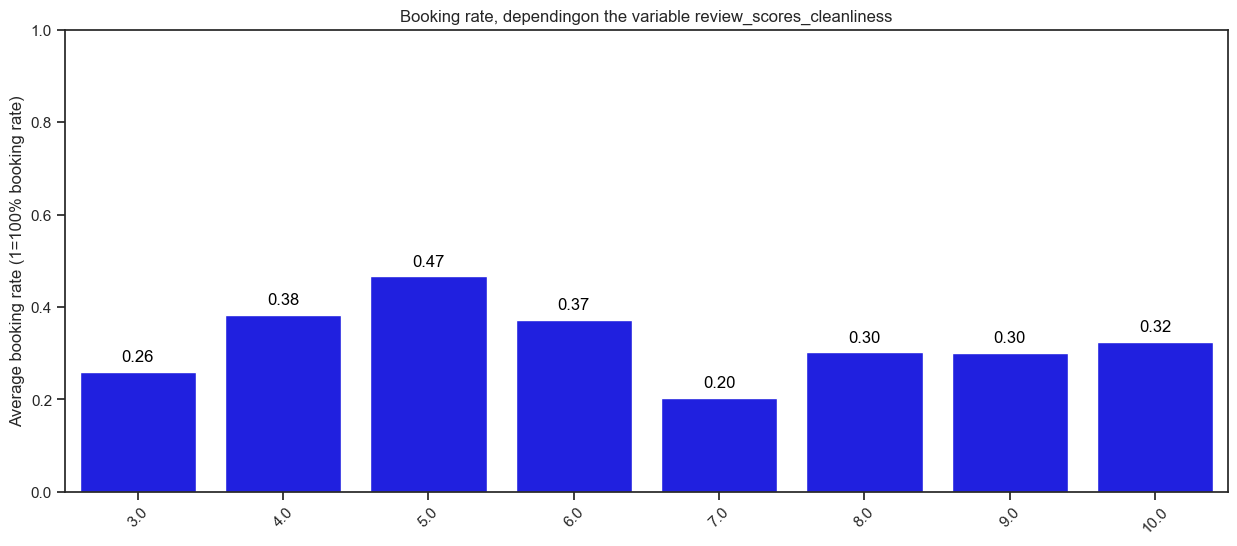

In [51]:
plot_average_rate(df_airbnb, 'review_scores_cleanliness', 'listing_booked', color='blue')

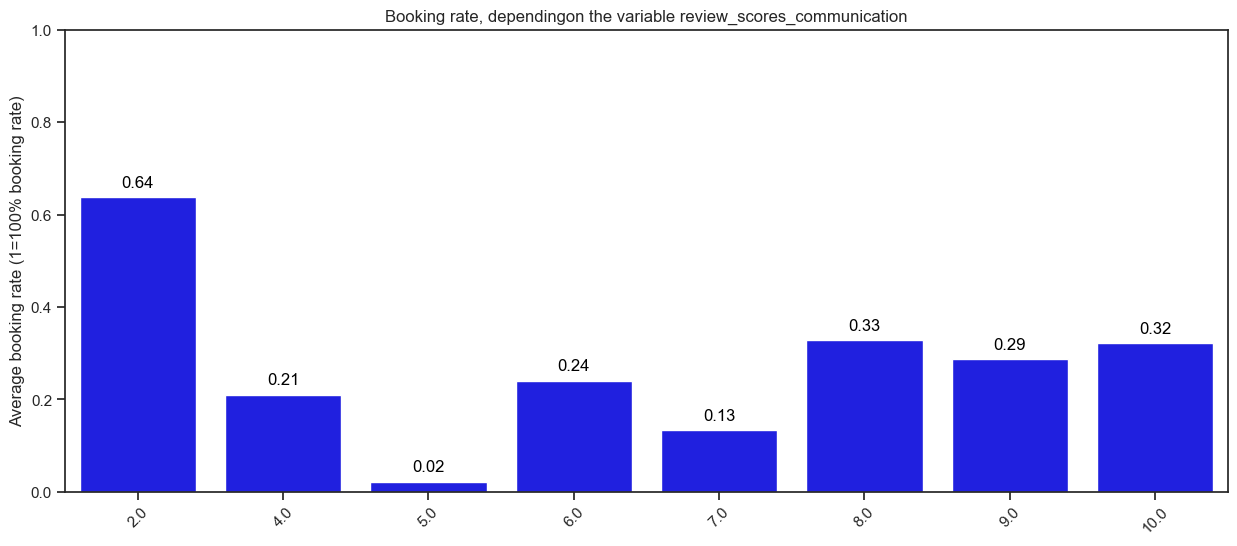

In [52]:
plot_average_rate(df_airbnb, 'review_scores_communication', 'listing_booked', color='blue')

We can also see that there does seem to be some effect of the scores on the likelly-hood to having a higher average booking rate. Lets see what the average is for missing values.

df_listings['review_scores_cleanliness'].value_counts()

In [53]:
df_airbnb[df_airbnb['review_scores_communication'].isnull()]['listing_booked'].mean()

np.float64(0.3876985880521011)

In [54]:
df_airbnb[df_airbnb['review_scores_cleanliness'].isnull()]['listing_booked'].mean()

np.float64(0.3877404602571902)

Here we see that we have a large share of reviews that are missing, where the booking share is actually quite large. We will group these individually, alongside review ratings 10, 9, 8-0.

#### 1.4.1.2 Data preparation

In [55]:
# replace nulls with 99 for identification
df_airbnb[['review_scores_communication', 'review_scores_cleanliness']]=df_airbnb[['review_scores_communication', 'review_scores_cleanliness']].fillna(99)

In [56]:
# lets use a function for categorization, since both variables has the same setup
## In this instance with many conditions, we will use np.select for the data wrangling
def group_ratings(df, variable):    
    cond = [
        df[variable] == 10,
        df[variable] == 9,
        df[variable] <= 8,
        df[variable] == 99
    ]

    # Create the choice: either keep the property_type or group it as 'Other'
    choices = ['{0}_rating_3_10'.format(variable), 
            '{0}_rating_2_9'.format(variable), 
            '{0}_rating_1_0_8'.format(variable), 
            '{0}_rating_4_missing'.format(variable)]


    # Use np.select to apply the conditions set above
    df['{0}_group'.format(variable)] = np.select(cond, choices, default='Other')

    return df

In [57]:
# Group communication reviews
df_airbnb=group_ratings(df_airbnb, 'review_scores_communication')

# Group cleanliness reviews
df_airbnb=group_ratings(df_airbnb, 'review_scores_cleanliness')

In [58]:
# Check that our grouping categories cover the correct ranges
df_airbnb.drop_duplicates(subset='listing_id')[['review_scores_communication_group','review_scores_communication']].value_counts()

review_scores_communication_group             review_scores_communication
review_scores_communication_rating_3_10       10.0                           2700
review_scores_communication_rating_4_missing  99.0                            651
review_scores_communication_rating_2_9        9.0                             388
review_scores_communication_rating_1_0_8      8.0                              56
                                              6.0                               8
                                              7.0                               8
                                              2.0                               3
                                              4.0                               3
                                              5.0                               1
Name: count, dtype: int64

In [59]:
# Check that our grouping categories cover the correct ranges
df_airbnb.drop_duplicates(subset='listing_id')[['review_scores_cleanliness_group','review_scores_cleanliness']].value_counts()

review_scores_cleanliness_group             review_scores_cleanliness
review_scores_cleanliness_rating_3_10       10.0                         2161
review_scores_cleanliness_rating_2_9        9.0                           740
review_scores_cleanliness_rating_4_missing  99.0                          653
review_scores_cleanliness_rating_1_0_8      8.0                           184
                                            7.0                            40
                                            6.0                            30
                                            5.0                             5
                                            4.0                             4
                                            3.0                             1
Name: count, dtype: int64

#### 1.4.1.3 Effect on KPI

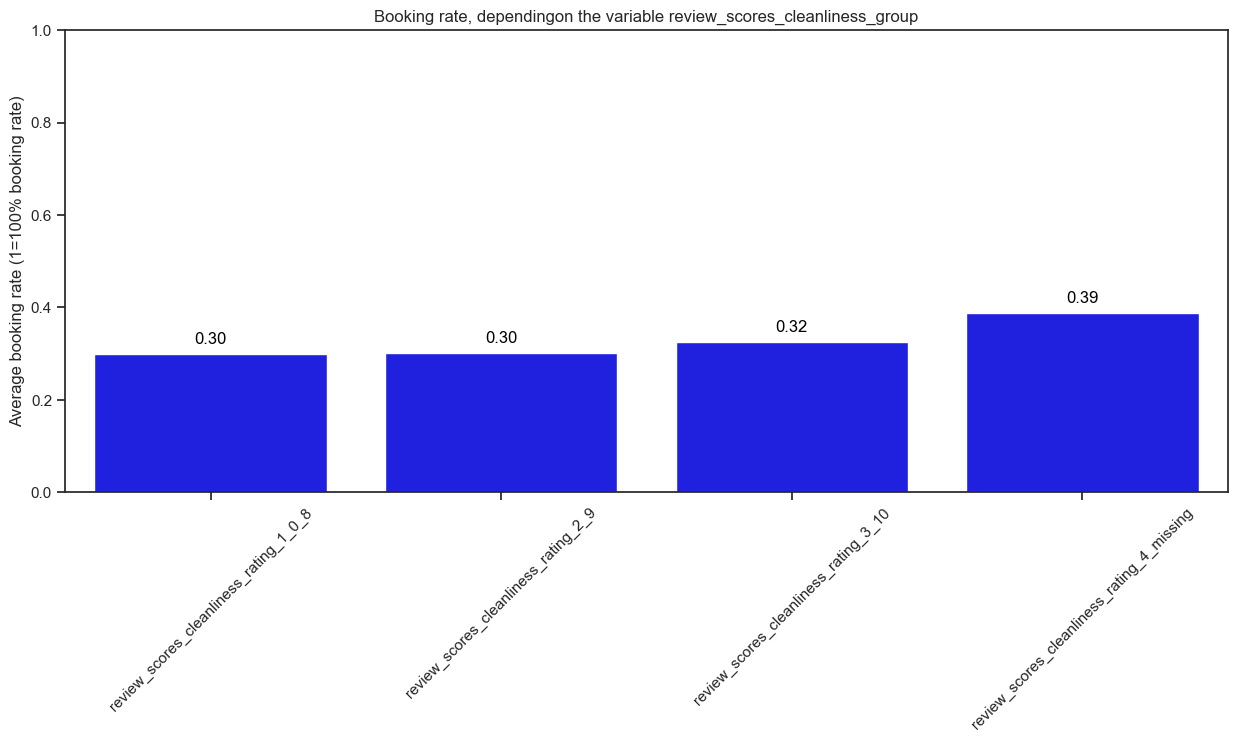

In [60]:
plot_average_rate(df_airbnb, 'review_scores_cleanliness_group', 'listing_booked', color='blue')

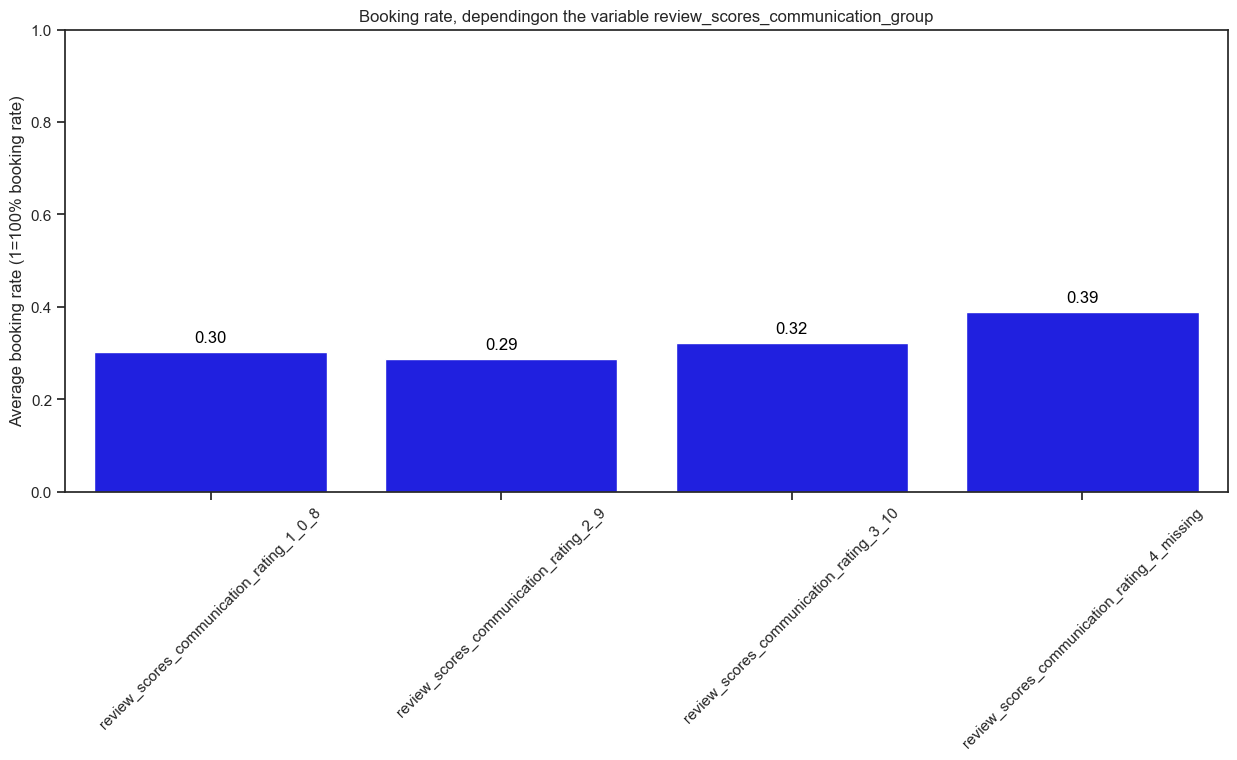

In [61]:
plot_average_rate(df_airbnb, 'review_scores_communication_group', 'listing_booked', color='blue')

#### Answers to question 3.1

Where we actually have reviews, there is a larger chance that the object has been booked if the listing has scored a 10. The result is not linear, however. It is not clear from the data that items belonging to owners which have a rating of 9 are in higher demand than object belonging to owners which are in lower demand.

The observations for missing values does not make sense for our analysis. It may be the case that these are listings that are less available due to owner restricting availability, and could therefore be dropped in a latter stage of the analysis.

In [62]:
# Get dummies
df_airbnb=get_dummy_cats(df_airbnb, 'review_scores_communication_group')

In [63]:
# check data
df_airbnb.iloc[:,-4:]

,review_scores_cleanliness_group,review_scores_communication_rating_2_9,review_scores_communication_rating_3_10,review_scores_communication_rating_4_missing
0,review_scores_cleanliness_rating_3_10,0,1,0
1,review_scores_cleanliness_rating_3_10,0,1,0
2,review_scores_cleanliness_rating_3_10,0,1,0
3,review_scores_cleanliness_rating_3_10,0,1,0
4,review_scores_cleanliness_rating_3_10,0,1,0
...,...,...,...,...
1393565,review_scores_cleanliness_rating_4_missing,0,0,1
1393566,review_scores_cleanliness_rating_4_missing,0,0,1
1393567,review_scores_cleanliness_rating_4_missing,0,0,1
1393568,review_scores_cleanliness_rating_4_missing,0,0,1


In [64]:
# Get dummies
df_airbnb=get_dummy_cats(df_airbnb, 'review_scores_cleanliness_group')

# check data
df_airbnb.iloc[:,-4:]

,review_scores_communication_rating_4_missing,review_scores_cleanliness_rating_2_9,review_scores_cleanliness_rating_3_10,review_scores_cleanliness_rating_4_missing
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0
...,...,...,...,...
1393565,1,0,0,1
1393566,1,0,0,1
1393567,1,0,0,1
1393568,1,0,0,1


In [65]:
# Drop the original variable not used for modelling
df_airbnb=df_airbnb.drop(columns=['review_scores_cleanliness','review_scores_communication'])

### 1.4.2 Variable: Reponse time

In [66]:
# Review scores, share of missing values
df_airbnb['host_response_time'].isnull().mean()

np.float64(0.13698271346254584)

We do have a large share of missing values. In this case we will drop missing values. A user who has not recieved any questions at all would most likelly be very non-active in renting out listings, and is therefor distrubting our data

In [67]:
df_airbnb=df_airbnb.dropna(subset=['host_response_time'])

In [68]:
# Review scores, share of missing values
df_airbnb['host_response_time'].isnull().mean()

np.float64(0.0)

#### 1.4.2.2 Data preparation

In [69]:
# Check the data
df_airbnb.drop_duplicates(subset='listing_id')['host_response_time'].value_counts()


host_response_time
within an hour        1692
within a few hours     968
within a day           597
a few days or more      38
Name: count, dtype: int64

No further preparation needed

#### 1.4.2.3 Effect on KPI

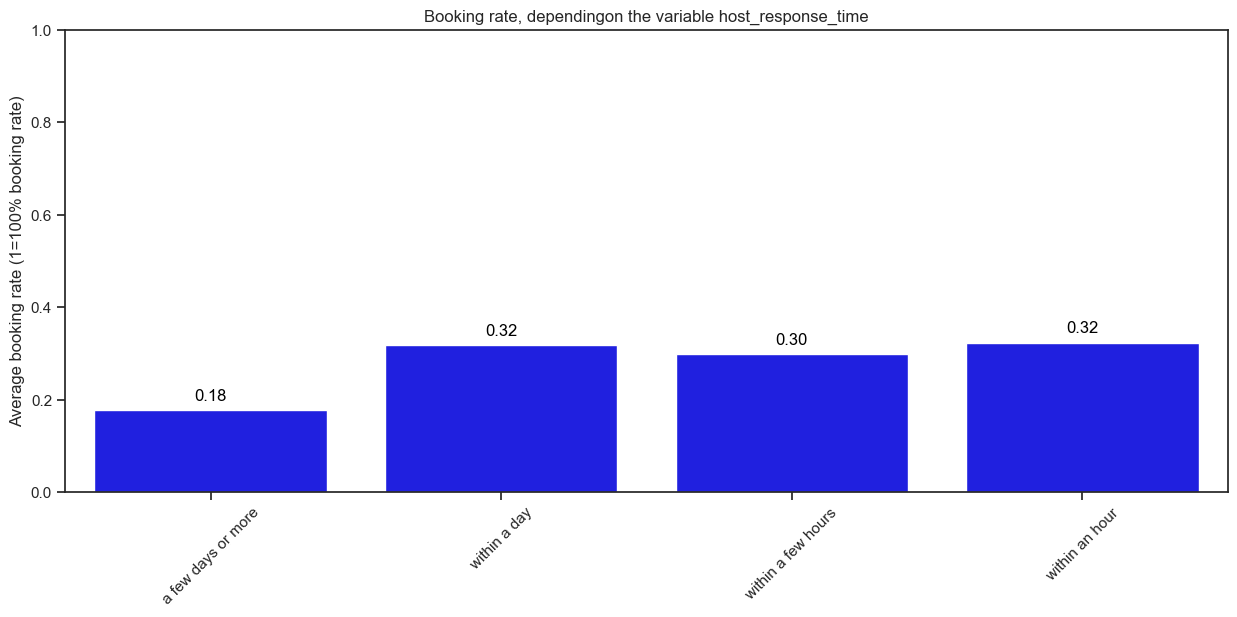

In [70]:
plot_average_rate(df_airbnb, 'host_response_time', 'listing_booked', color='blue')

In [71]:
# Get dummies
df_airbnb=get_dummy_cats(df_airbnb, 'host_response_time', prefix='resposetime')

# check data
df_airbnb.iloc[:,-8:]

,review_scores_communication_rating_3_10,review_scores_communication_rating_4_missing,review_scores_cleanliness_rating_2_9,review_scores_cleanliness_rating_3_10,review_scores_cleanliness_rating_4_missing,resposetime_within a day,resposetime_within a few hours,resposetime_within an hour
0,1,0,0,1,0,0,1,0
1,1,0,0,1,0,0,1,0
2,1,0,0,1,0,0,1,0
3,1,0,0,1,0,0,1,0
4,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...
1393565,0,1,0,0,1,1,0,0
1393566,0,1,0,0,1,1,0,0
1393567,0,1,0,0,1,1,0,0
1393568,0,1,0,0,1,1,0,0


### 1.4.3 Variable: Reponse rate

In [72]:
# Review scores, share of missing values
df_airbnb['host_response_rate'].isnull().mean()

np.float64(0.0)

#### 1.4.3.2 Data preparation

In [73]:
# Check the data
df_airbnb.drop_duplicates(subset='listing_id')['host_response_rate'].describe()

count     3295
unique      45
top       100%
freq      2371
Name: host_response_rate, dtype: object

Our first challenge is that what should be a percentage value is actually in datatype object. Change this to int.

In [74]:
# Change to a numeric datatype by removing the "%" string character.
df_airbnb['host_response_rate']=pd.to_numeric(df_airbnb['host_response_rate'].str.replace('%',''), errors='coerce')

In [75]:
# Check data distribution
df_airbnb.drop_duplicates(subset='listing_id')['host_response_rate'].describe()

count    3295.000000
mean       94.886798
std        11.866705
min        17.000000
25%        98.000000
50%       100.000000
75%       100.000000
max       100.000000
Name: host_response_rate, dtype: float64

In [76]:
# There is a large share of the data showing that the majority of owners respons 100% of the times
df_airbnb.drop_duplicates(subset='listing_id')['host_response_rate'].value_counts().reset_index().sort_values(by='host_response_rate')

,host_response_rate,count
33,17,2
27,25,3
38,30,1
35,31,1
19,33,14
39,38,1
20,40,12
26,43,4
5,50,52
41,53,1


Since such a large share of the listings have a 100% response rate we will categorize this variable as i 100%, Not 100% and missing.

In [77]:
# replace missing with -99
df_airbnb['host_response_rate'] = df_airbnb['host_response_rate'].fillna(-99)

# create a categorizations variable, using pd.cut (https://pandas.pydata.org/docs/reference/api/pandas.cut.html)
# Define the bins and labels to be used for the categorization. Set max value using 
bins = [
        0,
        90,
        95,
        100,
        101]

labels = [
        'host_response_rate_0_89', 
        'host_response_rate_90+',
        'host_response_rate_95+', 
        'host_response_rate_100']

# Use pd.cut to bin the data
df_airbnb['host_response_rate_cat'] = pd.cut(df_airbnb['host_response_rate'], bins=bins, labels=labels, right=False)

In [78]:
# Look at disribution
df_airbnb.drop_duplicates(subset='listing_id')['host_response_rate_cat'].value_counts()

host_response_rate_cat
host_response_rate_100     2371
host_response_rate_0_89     509
host_response_rate_90+      252
host_response_rate_95+      163
Name: count, dtype: int64

#### 1.4.3.3 Effect on KPI

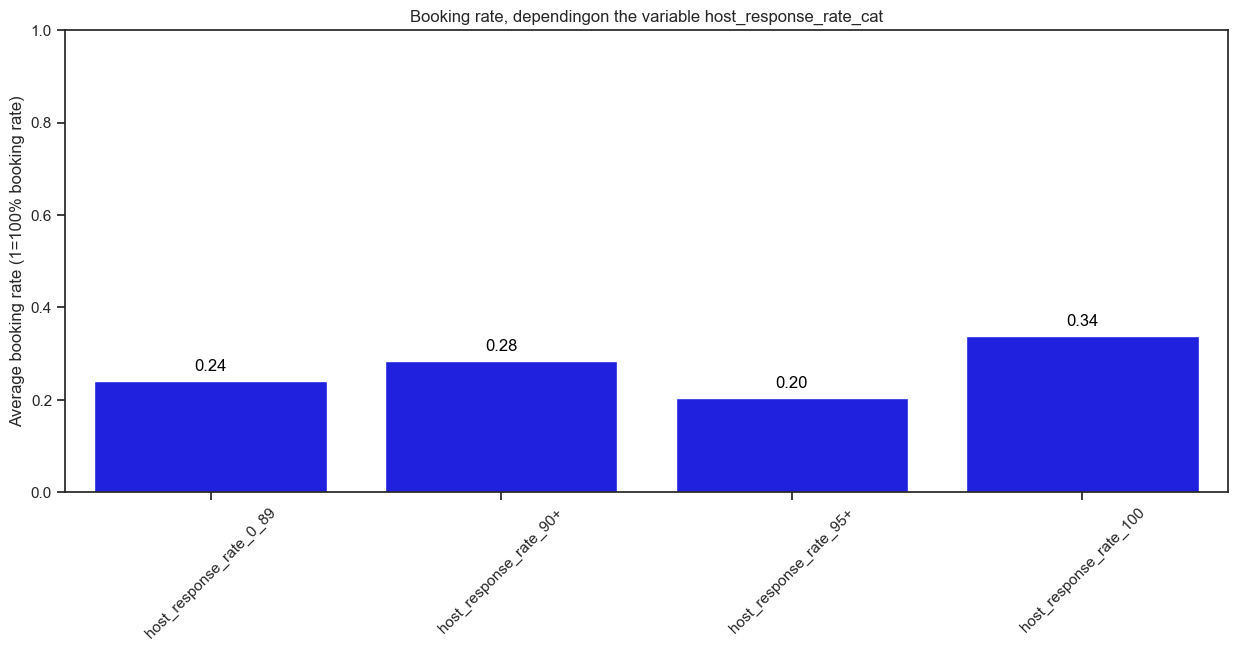

In [79]:
plot_average_rate(df_airbnb, 'host_response_rate_cat', 'listing_booked', color='blue')

### Answer to question 3.2

This result implies that customers are more likelly to book a stay with customers which have a response rate of 100%. As the response rate drops however, the relationship is less clear and there is no linear relationship between response rates and booking share.

It is also the case that the majority of customers have a 100% response rate, implying that this is simply expected and that anything else is seen as unexceptable.

In [80]:
# Get dummies
df_airbnb=get_dummy_cats(df_airbnb, 'host_response_rate_cat')

# check data
df_airbnb.iloc[:,-8:]

,review_scores_cleanliness_rating_4_missing,resposetime_within a day,resposetime_within a few hours,resposetime_within an hour,host_response_rate_cat,host_response_rate_90+,host_response_rate_95+,host_response_rate_100
0,0,0,1,0,host_response_rate_95+,0,1,0
1,0,0,1,0,host_response_rate_95+,0,1,0
2,0,0,1,0,host_response_rate_95+,0,1,0
3,0,0,1,0,host_response_rate_95+,0,1,0
4,0,0,1,0,host_response_rate_95+,0,1,0
...,...,...,...,...,...,...,...,...
1393565,1,1,0,0,host_response_rate_100,0,0,1
1393566,1,1,0,0,host_response_rate_100,0,0,1
1393567,1,1,0,0,host_response_rate_100,0,0,1
1393568,1,1,0,0,host_response_rate_100,0,0,1


In [81]:
# Drop the original variable not used for modelling
df_airbnb=df_airbnb.drop(columns='host_response_rate')

### 1.4.4 Variable: Description

##### 1.4.4.1 Missing data

In [82]:
# Check for missing data in the column
print('There are {0} instances of missing observations in the dataset'.format(df_airbnb['description'].isnull().sum()))

There are 0 instances of missing observations in the dataset


##### 1.4.4.2 Data preparation


In [83]:
# Since every description will be different there is no use in using it by itself. 
# However, looking at the length of the string may be insterresting, since it could point to a "sweetspot" lenght wise
df_airbnb['description']

0          Make your self at home in this charming one-be...
1          Make your self at home in this charming one-be...
2          Make your self at home in this charming one-be...
3          Make your self at home in this charming one-be...
4          Make your self at home in this charming one-be...
                                 ...                        
1393565    All hardwood floors, fireplace, 65" TV with Xb...
1393566    All hardwood floors, fireplace, 65" TV with Xb...
1393567    All hardwood floors, fireplace, 65" TV with Xb...
1393568    All hardwood floors, fireplace, 65" TV with Xb...
1393569    All hardwood floors, fireplace, 65" TV with Xb...
Name: description, Length: 1202675, dtype: object

In [84]:
# However, the data implies that airbnb uses a 1000 items max. 
df_airbnb['description'].str.len().describe()

# The descriptions imply that a large set of users use the maxing number of words, but a grouping variable may still be interesting

count    1.202675e+06
mean     8.886428e+02
std      2.467489e+02
min      1.100000e+01
25%      1.000000e+03
50%      1.000000e+03
75%      1.000000e+03
max      1.000000e+03
Name: description, dtype: float64

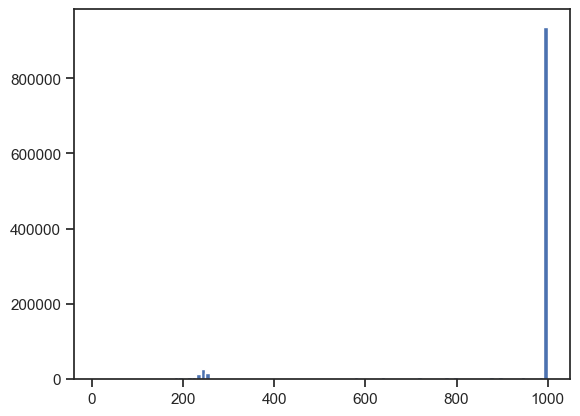

In [85]:
# Look at the lenght ranges
plt.hist(df_airbnb['description'].str.len(), bins=100);

In [86]:
# Get description lenght for each row
df_airbnb['desc_len']=df_airbnb['description'].str.len()

# create a categorizations variable, using pd.cut (https://pandas.pydata.org/docs/reference/api/pandas.cut.html)
# Define the bins and labels to be used for the categorization
bins = [0, 250, 500, 750, 1001]
labels = ['desc_0_250_w', 'desc_250_500_w', 'desc_500_550_w', 'desc_750_1000_words']

# Use pd.cut to bin the data
df_airbnb['description_cat'] = pd.cut(df_airbnb['desc_len'], bins=bins, labels=labels, right=False)

In [87]:
# Check the count of listings for each bin
df_airbnb.drop_duplicates(subset='listing_id')['description_cat'].value_counts()

description_cat
desc_750_1000_words    2749
desc_0_250_w            242
desc_500_550_w          161
desc_250_500_w          143
Name: count, dtype: int64

In [88]:
# Check that mean values are within the correct bins
df_airbnb.groupby('description_cat', observed=True)['desc_len'].mean()

description_cat
desc_0_250_w           202.082645
desc_250_500_w         358.699301
desc_500_550_w         626.571429
desc_750_1000_words    991.997817
Name: desc_len, dtype: float64

#### 1.4.4.3 Effect on KPI

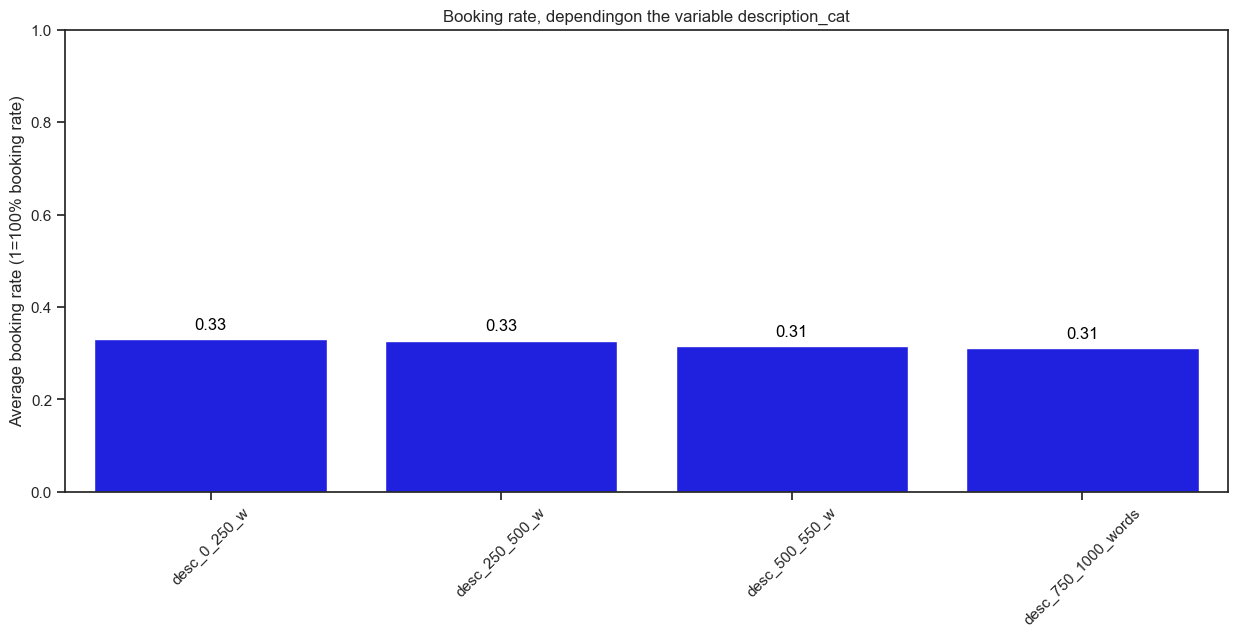

In [89]:
plot_average_rate(df_airbnb, 'description_cat', 'listing_booked', color='blue')

### Anser to question 3.3

The bookings rate does actually seem to fall with the amount of words used in the overall description. 

This could either be to the fact that these are more efficiently written, but we should be aware of that it could also be a spurious relationship where the most popular listings don't need a wordy description.


In [90]:
# Get dummies
df_airbnb=get_dummy_cats(df_airbnb, 'description_cat')

In [91]:
df_airbnb.iloc[:,-4:].head(10)

,description_cat,desc_250_500_w,desc_500_550_w,desc_750_1000_words
0,desc_750_1000_words,0,0,1
1,desc_750_1000_words,0,0,1
2,desc_750_1000_words,0,0,1
3,desc_750_1000_words,0,0,1
4,desc_750_1000_words,0,0,1
5,desc_750_1000_words,0,0,1
6,desc_750_1000_words,0,0,1
7,desc_750_1000_words,0,0,1
8,desc_750_1000_words,0,0,1
9,desc_750_1000_words,0,0,1


In [92]:
# Drop the original variable not used for modelling
df_airbnb=df_airbnb.drop(columns=['description','desc_len'])

### 1.4.5 Variable: Host about

#### 1.4.5.1 Variable: Host about

In [93]:
# Review scores, share of missing values
df_airbnb['host_about'].isnull().mean()

np.float64(0.1990895295902883)

We do have a large share of missing values. In this case we do want to replace the missing values with a marker, since this variable may inply a low activity rate for the owner. This is therefore one of our most interesting variables.

#### 1.4.5.2 Data preparation

In [94]:
# Check the data
df_airbnb.drop_duplicates(subset='listing_id')['host_about'].str.len().describe().astype(int)

count    2639
mean      473
std       445
min         3
25%       181
50%       374
75%       636
max      4354
Name: host_about, dtype: int64

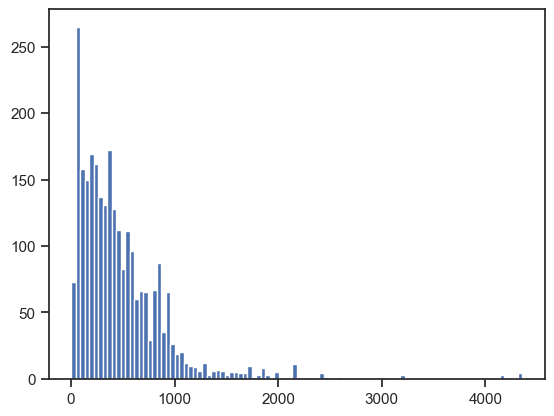

In [95]:
# Look at the lenght ranges
plt.hist(df_airbnb.drop_duplicates(subset='listing_id')['host_about'].str.len(), bins=100);

In [96]:
# Get description lenght for each row
df_airbnb['host_about_len']=df_airbnb['host_about'].str.len()

# replace missing with -99
df_airbnb['host_about_len'] = df_airbnb['host_about_len'].fillna(-99)

# create a categorizations variable, using pd.cut (https://pandas.pydata.org/docs/reference/api/pandas.cut.html)
# Define the bins and labels to be used for the categorization. Set max value using 
bins = [-100,
        0, 
        200, 
        400, 
        600, 
        800, 
        1000, 
        df_airbnb['host_about_len'].max()+1]

labels = [
        'host_about__missing',
        'host_about_0_200_w', 
        'host_about_200_400_w', 
        'host_about_400_600_w', 
        'host_about_600_800_w',
        'host_about_800_1000_w',
        'host_about_+1000_w']

# Use pd.cut to bin the data
df_airbnb['host_about_cat'] = pd.cut(df_airbnb['host_about_len'], bins=bins, labels=labels, right=False)

In [97]:
# Check the number of observations for each bin
df_airbnb.drop_duplicates(subset='listing_id')['host_about_cat'].value_counts()

host_about_cat
host_about_0_200_w       741
host_about_200_400_w     694
host_about__missing      656
host_about_400_600_w     497
host_about_600_800_w     278
host_about_800_1000_w    237
host_about_+1000_w       192
Name: count, dtype: int64

#### 1.4.5.3 Effect of variable on availability

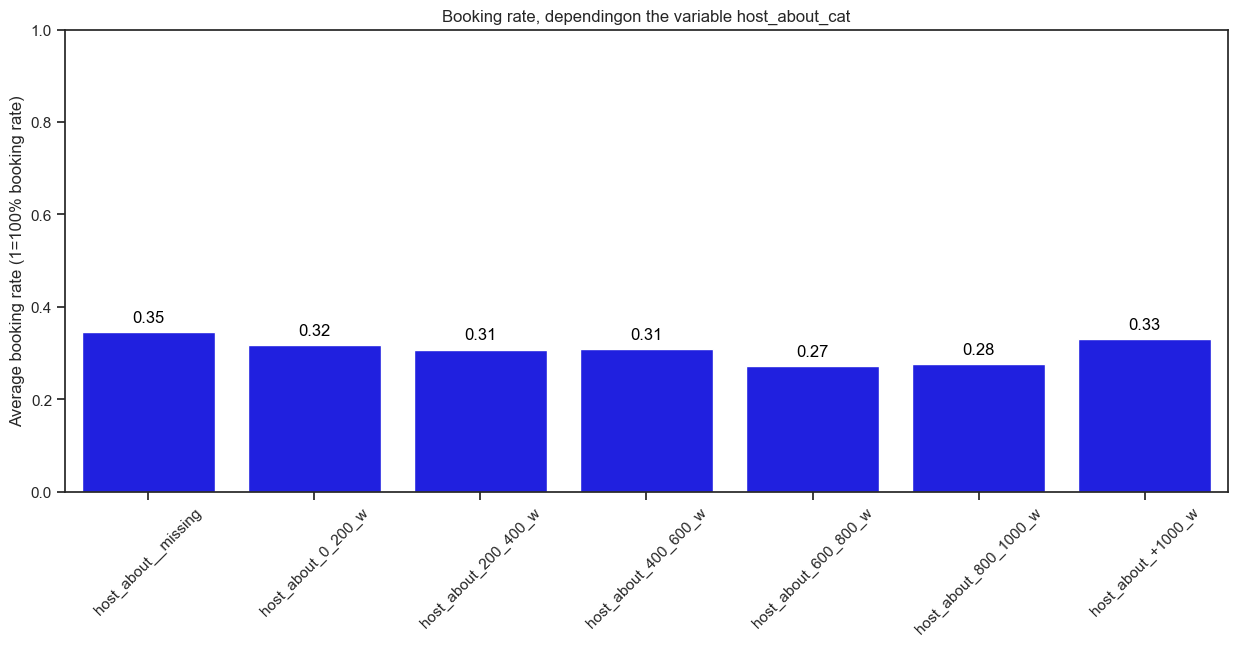

In [98]:
plot_average_rate(df_airbnb, 'host_about_cat', 'listing_booked', color='blue')

There does not seem to be any relationship between the number of words used in a user description and the avarge bookings rate

In [99]:
# One problem with my categorization above is the the missing column will be excluded from the dummy generation, as it is categorized as first category.
## In order to deal with this I will need to re-categorize my categories. This I will do using https://pandas.pydata.org/pandas-docs/version/0.25/reference/api/pandas.Series.cat.reorder_categories.html
about_order=['host_about_0_200_w',
            'host_about_200_400_w',
            'host_about_400_600_w',
            'host_about_600_800_w',
            'host_about_800_1000_w',
            'host_about_+1000_w',
            'host_about__missing']


df_airbnb['host_about_cat']=df_airbnb['host_about_cat'].cat.reorder_categories(about_order, ordered=True)

In [100]:
# Get dummies
df_airbnb=get_dummy_cats(df_airbnb, 'host_about_cat')

# check data
df_airbnb.iloc[:,-8:]

,host_about_len,host_about_cat,host_about_200_400_w,host_about_400_600_w,host_about_600_800_w,host_about_800_1000_w,host_about_+1000_w,host_about__missing
0,372.0,host_about_200_400_w,1,0,0,0,0,0
1,372.0,host_about_200_400_w,1,0,0,0,0,0
2,372.0,host_about_200_400_w,1,0,0,0,0,0
3,372.0,host_about_200_400_w,1,0,0,0,0,0
4,372.0,host_about_200_400_w,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...
1393565,-99.0,host_about__missing,0,0,0,0,0,1
1393566,-99.0,host_about__missing,0,0,0,0,0,1
1393567,-99.0,host_about__missing,0,0,0,0,0,1
1393568,-99.0,host_about__missing,0,0,0,0,0,1


In [101]:
# Drop the original variable not used for modelling
df_airbnb=df_airbnb.drop(columns=['host_about','host_about_len'])

## 1.5 Variables used as control variables in a datamodel

These are variables which are likelly to be important in explaining customer demand, but are not in focus for the questions that we seek to answer.

### 1.5.1 Variable: Price

##### 1.5.1.1 Missing data

In [102]:
# Contains information on wether or not the listing is available for renting. Price contains quite a large set of missing data
df_airbnb['price'].isnull().sum()

np.int64(0)

#### 1.5.1.2 Data preparation

In [103]:
# Our price variable is in the wrong datatype (str). We need this to be in int or float in order to work with the data.
df_airbnb.drop_duplicates(subset='listing_id').describe()

,listing_id,month,listing_booked,month_2,month_3,month_4,month_5,month_6,month_7,month_8,...,host_response_rate_100,desc_250_500_w,desc_500_550_w,desc_750_1000_words,host_about_200_400_w,host_about_400_600_w,host_about_600_800_w,host_about_800_1000_w,host_about_+1000_w,host_about__missing
count,3.295000e+03,3295.0,3295.000000,3295.0,3295.0,3295.0,3295.0,3295.0,3295.0,3295.0,...,3295.000000,3295.000000,3295.000000,3295.000000,3295.000000,3295.000000,3295.000000,3295.000000,3295.000000,3295.000000
mean,5.483676e+06,1.0,0.522610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.719575,0.043399,0.048862,0.834294,0.210622,0.150835,0.084370,0.071927,0.058270,0.199090
std,2.978144e+06,0.0,0.499564,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.449275,0.203785,0.215612,0.371873,0.407812,0.357942,0.277984,0.258406,0.234289,0.399376
min,3.335000e+03,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.144454e+06,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.992032e+06,1.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8.016628e+06,1.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.034016e+07,1.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [104]:
# Our data currently conatins non-numeric objects.
df_airbnb['price'].head()

0    $85.00
1    $85.00
2    $85.00
3    $85.00
4    $85.00
Name: price, dtype: object

In [105]:
# These needs to be removed. The strings to remove are '$' and ','
# https://pandas.pydata.org/docs/reference/api/pandas.to_numeric.html
df_airbnb['price_num']=df_airbnb['price'].str.replace(',','').str.replace('$','')
df_airbnb['price_num']=pd.to_numeric(df_airbnb['price_num']).astype('int')

In [106]:
# Check the count of listings for each bin
df_airbnb.drop_duplicates(subset='listing_id').describe().astype('int')

,listing_id,month,listing_booked,month_2,month_3,month_4,month_5,month_6,month_7,month_8,...,desc_250_500_w,desc_500_550_w,desc_750_1000_words,host_about_200_400_w,host_about_400_600_w,host_about_600_800_w,host_about_800_1000_w,host_about_+1000_w,host_about__missing,price_num
count,3295,3295,3295,3295,3295,3295,3295,3295,3295,3295,...,3295,3295,3295,3295,3295,3295,3295,3295,3295,3295
mean,5483675,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,124
std,2978144,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,87
min,3335,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,22
25%,3144454,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,72
50%,5992032,1,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,100
75%,8016628,1,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,150
max,10340165,1,1,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,999


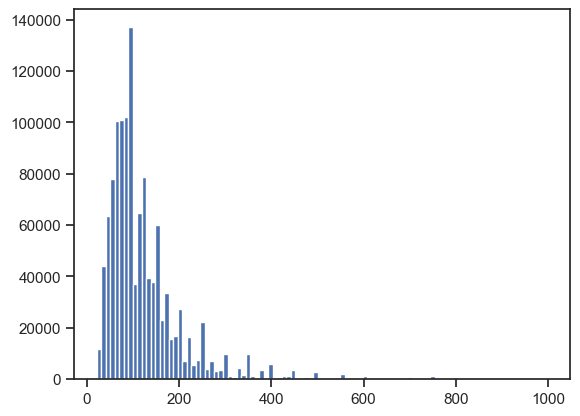

In [107]:
# Look at the price ranges
plt.hist(df_airbnb['price_num'], bins=100);

In [108]:
# create a categorizations variable, using pd.cut (https://pandas.pydata.org/docs/reference/api/pandas.cut.html)
# Define the bins and labels to be used for the categorization. Looking at the vizualisation above we should use a more granular set of bins below 200, and then increase the bin size.
bins = [0, 51, 101, 201, 301, 501, 751, 1001] 
labels = ['Price_0_50', 'Price_50_100', 'Price_100_200', 'Price_200_300', 'Price_300_500', 'Price_500_750', 'Price_750_1000']

# Use pd.cut to bin the data
df_airbnb['price_cat'] = pd.cut(df_airbnb['price_num'], bins=bins, labels=labels, right=False)

#### 1.5.1.3 Effect of variable on availability

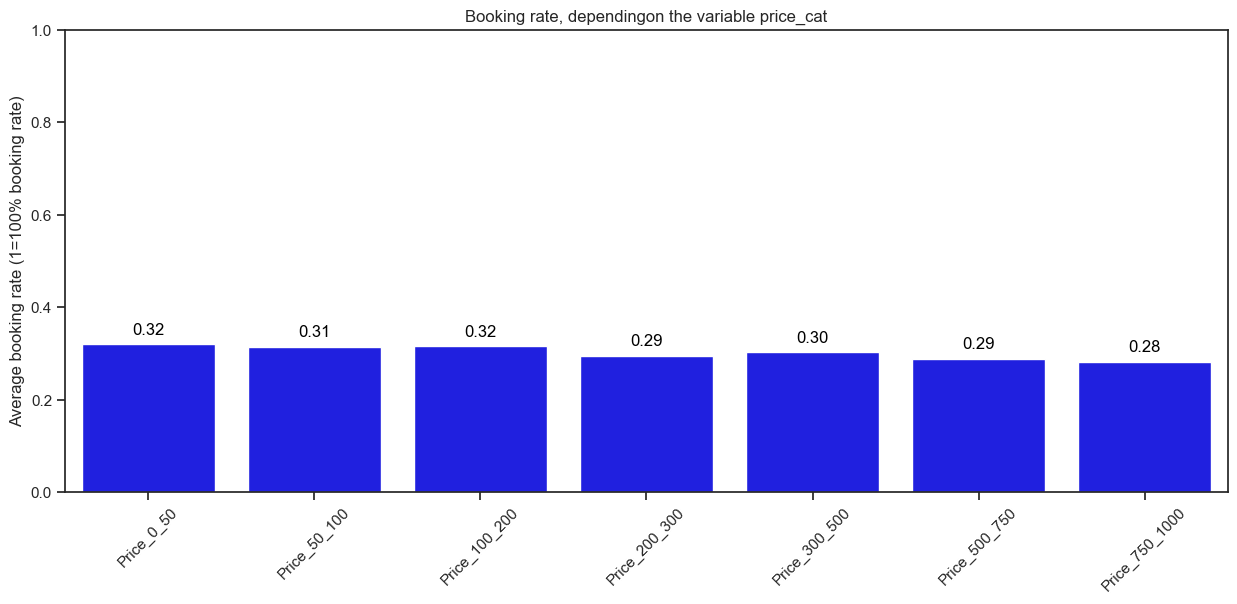

In [109]:
plot_average_rate(df_airbnb, 'price_cat', 'listing_booked', color='blue')

Price does indeed seem to affect the bookings rate, with accomodations in the mid-price range being booked at a higher rate

In [110]:
# Get dummies
df_airbnb=get_dummy_cats(df_airbnb, 'price_cat')

In [111]:
# Drop the original variable not used for modelling
df_airbnb=df_airbnb.drop(columns=['price','price_num'])

### 1.5.2 Variable: neighbourhood_group_cleansed

##### 1.5.2.1 Missing data

In [112]:
# Check for missing data in the column
print('There are {0} instances of missing observations in the dataset'.format(df_airbnb['neighbourhood_group_cleansed'].isnull().sum()))

There are 0 instances of missing observations in the dataset


#### 1.5.2.2 Data preparation


In [113]:
# We will use a neighbour variable to check for effects from neighborhoods
df_airbnb.drop_duplicates(subset='listing_id')['neighbourhood_group_cleansed'].value_counts().reset_index().sort_values(by='neighbourhood_group_cleansed')

,neighbourhood_group_cleansed,count
5,Ballard,204
9,Beacon Hill,105
2,Capitol Hill,475
11,Cascade,66
3,Central Area,320
12,Delridge,65
1,Downtown,488
16,Interbay,10
14,Lake City,52
13,Magnolia,55


#### 1.5.2.3. Effect on KPI

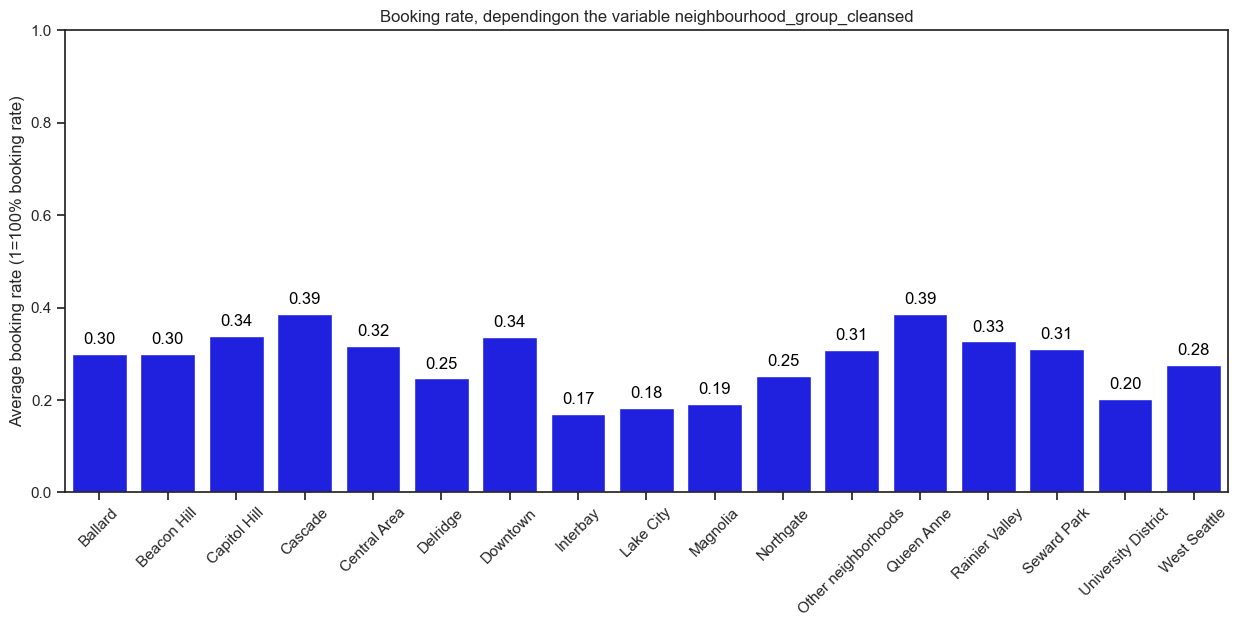

In [114]:
plot_average_rate(df_airbnb, 'neighbourhood_group_cleansed', 'listing_booked', color='blue')

There is clearly quite a difference in booking rate for the different areas. HOWEVER, looking at the number of observations above we should be aware that e.g. Interbay has a low number of items in the dataset and may therefor not be representative.

Since area will be used as a control variable in our model we will still keep it as it is for now and use the dummies for the model.

In [115]:
# Create dummies for the available neighbourhoods. Nieghbourhood Ballard will be used as standard
df_airbnb=get_dummy_cats(df_airbnb, 'neighbourhood_group_cleansed')

### 1.5.4. Variable: property_type

##### 1.5.4.1 Missing data

In [116]:
# Check for missing data in the column
print('There are {0} instances of missing observations in the dataset'.format(df_airbnb['property_type'].isnull().sum()))

There are 365 instances of missing observations in the dataset


In [117]:
#since we only have one variable missing, and it is an important variable I will choose to drop it
df_airbnb.dropna(subset='property_type', inplace=True)

# Check for missing data in the column
print('There are {0} instances of missing observations in the dataset'.format(df_airbnb['property_type'].isnull().sum()))

There are 0 instances of missing observations in the dataset


#### 1.5.4.2 Data preparation


In [118]:
# Look at the number of listings for each category
df_airbnb.drop_duplicates(subset='listing_id')['property_type'].value_counts()

property_type
House              1494
Apartment          1474
Townhouse           102
Condominium          84
Loft                 34
Bed & Breakfast      30
Other                21
Cabin                20
Bungalow             13
Camper/RV            10
Boat                  5
Dorm                  2
Chalet                2
Yurt                  1
Tent                  1
Treehouse             1
Name: count, dtype: int64

In [119]:
# Since we have quite a large number of housing types with a few number of variables, we will add these to the "Other" category
## In this instance with many conditions, we will use np.select for the data wrangling

cond = [
    df_airbnb['property_type'] == 'House',
    df_airbnb['property_type'] == 'Apartment',
    df_airbnb['property_type'] == 'Townhouse',
    df_airbnb['property_type'] == 'Condominium',
    df_airbnb['property_type'] == 'Loft',
    df_airbnb['property_type'] == 'Bed & Breakfast'
]

# Create the choice: either keep the property_type or group it as 'Other'
choices = ['House', 
        'Apartment', 
        'Townhouse', 
        'Condominium', 
        'Loft', 
        'Bed & Breakfast']


# Use np.select to apply the conditions set above
df_airbnb['grouped_property_type'] = np.select(cond, choices, default='Other')

In [120]:
# Look at the number of listings for each category
df_airbnb.drop_duplicates(subset='listing_id')[['property_type','grouped_property_type']].value_counts()

property_type    grouped_property_type
House            House                    1494
Apartment        Apartment                1474
Townhouse        Townhouse                 102
Condominium      Condominium                84
Loft             Loft                       34
Bed & Breakfast  Bed & Breakfast            30
Other            Other                      21
Cabin            Other                      20
Bungalow         Other                      13
Camper/RV        Other                      10
Boat             Other                       5
Chalet           Other                       2
Dorm             Other                       2
Tent             Other                       1
Treehouse        Other                       1
Yurt             Other                       1
Name: count, dtype: int64

#### 1.5.4.3 Effect on KPI

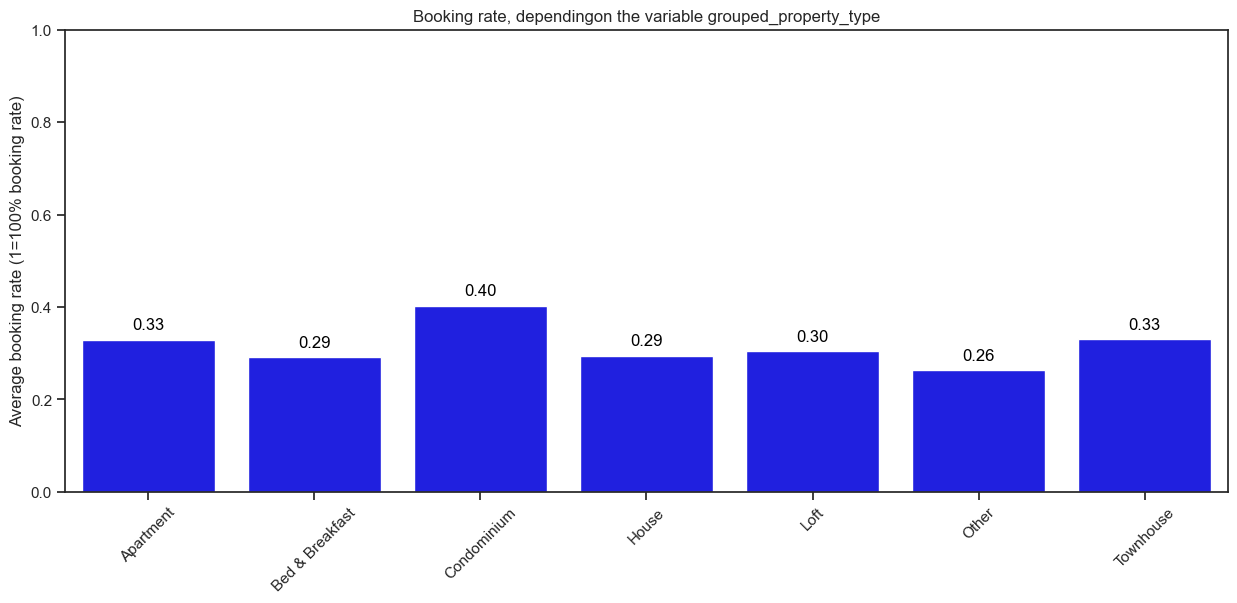

In [121]:
plot_average_rate(df_airbnb, 'grouped_property_type', 'listing_booked', color='blue')

Looking at this data, it seems as if condiminiums and townhouses are the most popular property types to pre book. Bed & Breakfast is the least popular defined option in the list.

In [122]:
# Get dummies
# Create dummies for the available neighbourhoods. Apartment will be used as standard value (i.e. will not be included as a dummy)
df_airbnb=get_dummy_cats(df_airbnb, 'grouped_property_type')

In [123]:
# Look at the dummies and check if they look appropriate
df_airbnb.iloc[:,-13:].head()

,Other neighborhoods,Queen Anne,Rainier Valley,Seward Park,University District,West Seattle,grouped_property_type,Bed & Breakfast,Condominium,House,Loft,Other,Townhouse
0,0,1,0,0,0,0,Apartment,0,0,0,0,0,0
1,0,1,0,0,0,0,Apartment,0,0,0,0,0,0
2,0,1,0,0,0,0,Apartment,0,0,0,0,0,0
3,0,1,0,0,0,0,Apartment,0,0,0,0,0,0
4,0,1,0,0,0,0,Apartment,0,0,0,0,0,0


In [124]:
# Drop the original variable not used for modelling
df_airbnb=df_airbnb.drop(columns='property_type')

### 1.5.5 Variable: room type

#### 1.5.5.1 Missing data

In [125]:
# Check for missing data in the column
print('There are {0} instances of missing observations in the dataset'.format(df_airbnb['room_type'].isnull().sum()))

There are 0 instances of missing observations in the dataset


#### 1.5.5.2 Data preparation


In [126]:
# Look at the number of listings for each category
df_airbnb.drop_duplicates(subset='listing_id')['room_type'].value_counts()

room_type
Entire home/apt    2206
Private room        981
Shared room         107
Name: count, dtype: int64

#### 1.5.5.3 Effect on KPI

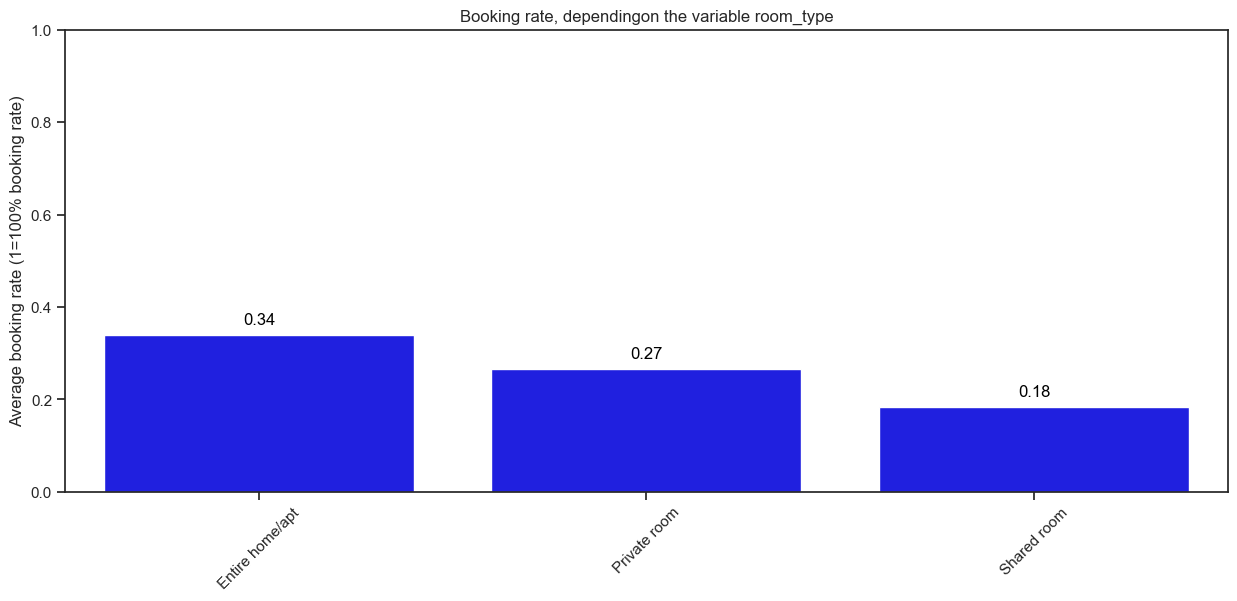

In [127]:
plot_average_rate(df_airbnb, 'room_type', 'listing_booked', color='blue')

In [128]:
# Get dummies
# Create dummies for the available neighbourhoods. Entire home/apt will be used as base value
df_airbnb=get_dummy_cats(df_airbnb, 'room_type')

In [129]:
# Look at the dummies and check if they look appropriate
df_airbnb.iloc[:,-7:].head(3)

,Condominium,House,Loft,Other,Townhouse,Private room,Shared room
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0


In [130]:
# Change column names
df_airbnb=df_airbnb.rename(columns={'Private room':'room_type_priv_room',
                                    'Shared room': 'room_type_shared_room'})

In [131]:
# Look at the dummies and check if they look appropriate
df_airbnb.iloc[:,-7:].head(3)

,Condominium,House,Loft,Other,Townhouse,room_type_priv_room,room_type_shared_room
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0


### 1.5.6 Variable: accommodates

#### 1.5.6.1 Missing data

In [132]:
# Check for missing data in the column
print('There are {0} instances of missing observations in the dataset'.format(df_airbnb['accommodates'].isnull().sum()))

There are 0 instances of missing observations in the dataset


#### 1.5.6.2 Data preparation

In [133]:
# Vizualise the data
df_airbnb.drop_duplicates(subset='listing_id')['accommodates'].value_counts()

accommodates
2     1373
4      691
3      348
6      303
1      215
5      159
8       99
7       46
10      23
12      14
9       12
16       4
11       3
15       2
14       2
Name: count, dtype: int64

This implies that eventhough our data is treated as a non-finite value, it is in fact categorical. In order to make the data more comprehenseble we will categorize it further.

In [134]:
# create a categorizations variable, using pd.cut (https://pandas.pydata.org/docs/reference/api/pandas.cut.html)
# Define the bins and labels to be used for the categorization. I will group the data in bins if two up til 8, and then group the rest upwards.
bins = [0, 3, 5, 7, 9, 100] 
labels = ['Accom_1_2', 'Accom_3_4', 'Accom_5_6', 'Accom_7_8', 'Accom_8+']

# Use pd.cut to bin the data
df_airbnb['accommodates_cat'] = pd.cut(df_airbnb['accommodates'], bins=bins, labels=labels, right=False)

In [135]:
# Check that our grouping looks good.
df_airbnb[['accommodates_cat', 'accommodates']].value_counts().reset_index().sort_values(by=['accommodates_cat','accommodates'])

,accommodates_cat,accommodates,count
4,Accom_1_2,1,78475
0,Accom_1_2,2,501145
2,Accom_3_4,3,127020
1,Accom_3_4,4,252215
5,Accom_5_6,5,58035
3,Accom_5_6,6,110595
7,Accom_7_8,7,16790
6,Accom_7_8,8,36135
10,Accom_8+,9,4380
8,Accom_8+,10,8395


#### 1.3.4.3 Effect on KPI

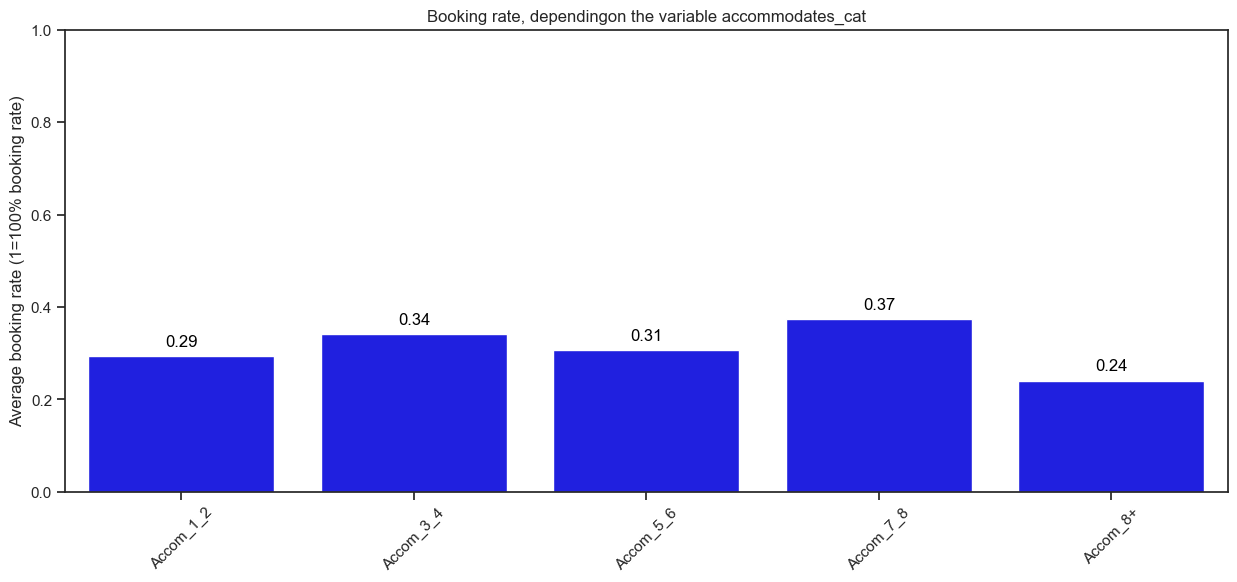

In [136]:
plot_average_rate(df_airbnb, 'accommodates_cat', 'listing_booked', color='blue')

There are clear differences in the categories, however not in any clear order. We will keep them as controll variables in any respect.

In [137]:
# Get dummies
# Create dummies for the available neighbourhoods. Accom_1_2 will be the base (excluded)
df_airbnb=get_dummy_cats(df_airbnb, 'accommodates_cat')

In [138]:
# Look at the dummies and check if they look appropriate
df_airbnb.iloc[:,-7:].head(5)

,room_type_priv_room,room_type_shared_room,accommodates_cat,Accom_3_4,Accom_5_6,Accom_7_8,Accom_8+
0,0,0,Accom_3_4,1,0,0,0
1,0,0,Accom_3_4,1,0,0,0
2,0,0,Accom_3_4,1,0,0,0
3,0,0,Accom_3_4,1,0,0,0
4,0,0,Accom_3_4,1,0,0,0


In [139]:
# Drop the original variable not used for modelling
df_airbnb=df_airbnb.drop(columns='accommodates')

# 2. Modeling
## - CRISP-DM steps 4-5

In [152]:
# Select columns use for our initial model
model_columns= ['listing_booked',
                'month_2',
                'month_3',
                'month_4',
                'month_5',
                'month_6',
                'month_7',
                'month_8',
                'month_9',
                'month_10',
                'month_11',
                'month_12',
                'review_scores_communication_rating_2_9',
                'review_scores_communication_rating_3_10',
                'review_scores_communication_rating_4_missing',
                'review_scores_cleanliness_rating_2_9',
                'review_scores_cleanliness_rating_3_10',
                'review_scores_cleanliness_rating_4_missing',
                'resposetime_within a day',
                'resposetime_within a few hours',
                'resposetime_within an hour',
                'host_response_rate_90+',
                'host_response_rate_95+',
                'host_response_rate_100',
                'desc_250_500_w',
                'desc_500_550_w',
                'desc_750_1000_words',
                'host_about_200_400_w',
                'host_about_400_600_w',
                'host_about_600_800_w',
                'host_about_800_1000_w',
                'host_about_+1000_w',
                'host_about__missing',
                'Price_50_100',
                'Price_100_200',
                'Price_200_300',
                'Price_300_500',
                'Price_500_750',
                'Price_750_1000',
                'Beacon Hill',
                'Capitol Hill',
                'Cascade',
                'Central Area',
                'Delridge',
                'Downtown',
                'Interbay',
                'Lake City',
                'Magnolia',
                'Northgate',
                'Other neighborhoods',
                'Queen Anne',
                'Rainier Valley',
                'Seward Park',
                'University District',
                'West Seattle',
                'Bed & Breakfast',
                'Condominium',
                'House',
                'Loft',
                'Other',
                'Townhouse',
                'room_type_priv_room',
                'room_type_shared_room',
                'Accom_3_4',
                'Accom_5_6',
                'Accom_7_8',
                'Accom_8+']

In [153]:
# Generate the modelling dataframe
airbnb_model=df_airbnb[model_columns]

These are the variables I will use for my model. I will use OLS as a rough estimate of the strenght of my model and the individual predictors.

* However, my dependend variable is binary. This means that using OLS is suboptimal, and may lead to biased and incorrect results. For example, the OLS implies a linear relationship for the model, which means that there is no upper boundery in the model - which is in reality 1. This may cause implossibly large coefficients.  For further analysis, and more precise modelling, a logit model would be recomended. I have used the same modeling

My target variables in the model are "host_about", "resposetime" and "host_response_rate". Which will be tested in chapter 2.2.

## 2.1. Overall predicatiblity

In [154]:
# I will use all explanatory variables for the dataset above, i.e. all variables except for listing_booked, which is my y-variable, and listing_id which is no longer necessary unless i panel-data model would be intereseting in the future
## Get all of the explanatory variables using iloc.
x_variables=list(airbnb_model.iloc[:,1:].columns)

In [155]:
# run the function to get test_score (how well my model behaves on actual data) and train_score (how well my model behaves on the training data)
test_score, train_score = clean_fit_linear_mod(airbnb_model, 'listing_booked', x_variables)

In [157]:
# model r2 tscore when applied to the training dataset
train_score

0.052340180106788314

In [141]:
# model r2 tscore when applied to the largesr testing data (how well the model works on "new data")
test_score

0.05258643527078699

Key takeaways: 
Both scores (0.052 for both) tells us that our prediction score when it comes to predicting listing_booked using the variables in the model is very small. We can only explain appr. 5% of the variation in lisings_booked. This may either depend on the model being insuffient, I have incorrect explanatory variables, or my listings_booked variable is badly defined.

Since we have made an assumtion regarding listing_booked being 1 owing to the item being unavailable since it has been booked by a customer, we have looked for items possitivelly, or negatively, affecting that likellyhood of a customer taking interest in that item.

But if listing_booked is more likelly to measure that the owner has not made it available, all such correlations fall. In fact, it may be the case that the item is less likelly to be available if the owner isn't that active, either in making it available in the system OR answering questions, putting an effort into writing a description, etc.

In order to dig deaper, we would need to know which items were actually unavailable because they were booked by a customer.

## 2.2. individual predictability of variables

In [161]:
ols_summary(airbnb_model, 'listing_booked', x_variables)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         listing_booked   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     1008.
Date:                Fri, 25 Oct 2024   Prob (F-statistic):               0.00
Time:                        07:30:42   Log-Likelihood:            -7.4990e+05
No. Observations:             1202310   AIC:                         1.500e+06
Df Residuals:                 1202243   BIC:                         1.501e+06
Df Model:                          66                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                            0.4403      0.006     76.186      0.000       0.429       0.452
month_2                                         -0.1068      0.002    -52.135      0.000      -0.111      -0.103
month_3                                         -0.1529      0.002    -75.903      0.000      -0.157      -0.149
month_4                                         -0.1024      0.002    -50.399      0.000      -0.106      -0.098
month_5                                         -0.1132      0.002    -56.163      0.000      -0.117      -0.109
month_6                                         -0.1060      0.002    -52.192      0.000      -0.110      -0.102
month_7                                         -0.0455      0.002    -22.581      0.000      -0.049      -0.042
month_8                                         -0.0600      0.002    -29.789      0.000      -0.064      -0.056
month_9                                         -0.0832      0.002    -40.963      0.000      -0.087      -0.079
month_10                                        -0.1000      0.002    -49.640      0.000      -0.104      -0.096
month_11                                        -0.1167      0.002    -57.458      0.000      -0.121      -0.113
month_12                                        -0.1371      0.002    -68.038      0.000      -0.141      -0.133
review_scores_communication_rating_2_9          -0.0315      0.003     -9.912      0.000      -0.038      -0.025
review_scores_communication_rating_3_10         -0.0254      0.003     -8.344      0.000      -0.031      -0.019
review_scores_communication_rating_4_missing     0.4753      0.024     19.844      0.000       0.428       0.522
review_scores_cleanliness_rating_2_9             0.0056      0.002      2.889      0.004       0.002       0.009
review_scores_cleanliness_rating_3_10            0.0210      0.002     11.413      0.000       0.017       0.025
review_scores_cleanliness_rating_4_missing      -0.4198      0.024    -17.631      0.000      -0.467      -0.373
resposetime_within a day                         0.0636      0.004     15.638      0.000       0.056       0.072
resposetime_within a few hours                   0.0242      0.004      5.879      0.000       0.016       0.032
resposetime_within an hour                       0.0305      0.004      7.370      0.000       0.022       0.039
host_response_rate_90+                           0.0800      0.002     40.251      0.000       0.076       0.084
host_response_rate_95+                          -0.0516      0.002    -22.040      0.000      -0.056      -0.047
host_response_rate_100                           0.1230      0.001     89.925      0.000       0.120       0.126
desc_250_500_w                  

This data implies 2 large issues with the model: 
1. OLS is suboptimal in analysing this dataset as it implies a linear model which we do not have. E.g. the coefficients for our constant (0.4403) and review_scores_communication_rating_4_missing (0.4753) in combination implies and implossibally large booking share. A binary model such as logit should be implemented. An initial attempt using statsmodels logit package unfortunatelly implies that this would require more computational power than the author of this report currently has access to.

2. The coefficients for our missing values, such as review_scores_communication_rating_4_missing, are extremelly large in proportion to the overall shares we have observed in the data. We should check what happens if these are removed, i.e. missing values dropped, and check the result.

### 2.2.1. Reduced model 1 - Remove null values

In [188]:
# Remove all missing values, by droping rows where either of the null-variables host_about__missing, review_scores_cleanliness_rating_4_missing or review_scores_communication_rating_4_missing are 1
df_airbnb_reduced = df_airbnb[~(df_airbnb['host_about__missing'] == 1) &
                        ~(df_airbnb['review_scores_cleanliness_rating_4_missing'] == 1) &
                        ~(df_airbnb['review_scores_communication_rating_4_missing'] == 1)
                        ]

In [189]:
# Check all columns for 1:s, drop them if they are all 0.
null_columns=['host_about__missing', 'review_scores_cleanliness_rating_4_missing', 'review_scores_communication_rating_4_missing']

for col in null_columns:    
    if df_airbnb_reduced[col].sum()==0:
        print("Missing data are removed")
    else:
        print("Missing data still present")

Missing data are removed
Missing data are removed
Missing data are removed


In [190]:
# Select all columns to be used in the reduced model
model_2_columns= ['listing_booked',
                'month_2',
                'month_3',
                'month_4',
                'month_5',
                'month_6',
                'month_7',
                'month_8',
                'month_9',
                'month_10',
                'month_11',
                'month_12',
                'review_scores_communication_rating_2_9',
                'review_scores_communication_rating_3_10',
                'review_scores_cleanliness_rating_2_9',
                'review_scores_cleanliness_rating_3_10',
                'resposetime_within a day',
                'resposetime_within a few hours',
                'resposetime_within an hour',
                'host_response_rate_90+',
                'host_response_rate_95+',
                'host_response_rate_100',
                'desc_250_500_w',
                'desc_500_550_w',
                'desc_750_1000_words',
                'host_about_200_400_w',
                'host_about_400_600_w',
                'host_about_600_800_w',
                'host_about_800_1000_w',
                'host_about_+1000_w',
                'Price_50_100',
                'Price_100_200',
                'Price_200_300',
                'Price_300_500',
                'Price_500_750',
                'Price_750_1000',
                'Beacon Hill',
                'Capitol Hill',
                'Cascade',
                'Central Area',
                'Delridge',
                'Downtown',
                'Interbay',
                'Lake City',
                'Magnolia',
                'Northgate',
                'Other neighborhoods',
                'Queen Anne',
                'Rainier Valley',
                'Seward Park',
                'University District',
                'West Seattle',
                'Bed & Breakfast',
                'Condominium',
                'House',
                'Loft',
                'Other',
                'Townhouse',
                'room_type_priv_room',
                'room_type_shared_room',
                'Accom_3_4',
                'Accom_5_6',
                'Accom_7_8',
                'Accom_8+']

In [191]:
# Generate the modelling dataframe
airbnb_model_2=df_airbnb_reduced[model_2_columns]

In [192]:
# See how many rows we have lost
lost_rows=airbnb_model.shape[0]-airbnb_model_2.shape[0]
lost_rows_share=(lost_rows/airbnb_model.shape[0])*100

print('We have dropped {0} rows, i.e. {1}% of the entire sample'.format(lost_rows, lost_rows_share))

We have dropped 337625 rows, i.e. 28.081360048573163% of the entire sample


In [193]:
# Get the x variables of the reduced model
x_variables_reduced=list(airbnb_model_2.iloc[:,1:].columns)

In [194]:
# Test our model one more time
ols_summary(airbnb_model_2, 'listing_booked', x_variables_reduced)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         listing_booked   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     641.8
Date:                Fri, 25 Oct 2024   Prob (F-statistic):               0.00
Time:                        07:49:17   Log-Likelihood:            -5.3036e+05
No. Observations:              864685   AIC:                         1.061e+06
Df Residuals:                  864621   BIC:                         1.062e+06
Df Model:                          63                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                       0.4051      0.007     54.152      0.000       0.390       0.420
month_2                                    -0.1204      0.002    -50.365      0.000      -0.125      -0.116
month_3                                    -0.1731      0.002    -73.628      0.000      -0.178      -0.169
month_4                                    -0.1263      0.002    -53.263      0.000      -0.131      -0.122
month_5                                    -0.1350      0.002    -57.401      0.000      -0.140      -0.130
month_6                                    -0.1251      0.002    -52.782      0.000      -0.130      -0.120
month_7                                    -0.0549      0.002    -23.348      0.000      -0.060      -0.050
month_8                                    -0.0685      0.002    -29.145      0.000      -0.073      -0.064
month_9                                    -0.0934      0.002    -39.402      0.000      -0.098      -0.089
month_10                                   -0.1084      0.002    -46.114      0.000      -0.113      -0.104
month_11                                   -0.1209      0.002    -51.001      0.000      -0.126      -0.116
month_12                                   -0.1335      0.002    -56.799      0.000      -0.138      -0.129
review_scores_communication_rating_2_9     -0.0438      0.004    -11.924      0.000      -0.051      -0.037
review_scores_communication_rating_3_10    -0.0118      0.004     -3.313      0.001      -0.019      -0.005
review_scores_cleanliness_rating_2_9       -0.0169      0.002     -7.729      0.000      -0.021      -0.013
review_scores_cleanliness_rating_3_10       0.0148      0.002      7.011      0.000       0.011       0.019
resposetime_within a day                    0.1486      0.006     26.830      0.000       0.138       0.159
resposetime_within a few hours              0.1351      0.006     24.170      0.000       0.124       0.146
resposetime_within an hour                  0.1163      0.006     20.727      0.000       0.105       0.127
host_response_rate_90+                      0.0707      0.002     30.623      0.000       0.066       0.075
host_response_rate_95+                     -0.0051      0.003     -1.765      0.078      -0.011       0.001
host_response_rate_100                      0.0991      0.002     58.542      0.000       0.096       0.102
desc_250_500_w                             -0.0160      0.004     -3.920      0.000      -0.024      -0.008
desc_500_550_w                             -0.0548      0.004    -14.402      0.000      -0.062      -0.047
desc_750_1000_words                        -0.0456      0.003    -16.351      0.000      -0.051      -0.040
host_about_200_400_w                       -0.0076      0.0

Comment: 

The result above still contains some improbable results, with nearly every coefficient being statistically significant (p-value<0.05). One obvious reason for this is the number of observations for each listing (we have a full set yearly of data for all items), which may reduce our standard errors to an extent that even insignificant differences in the data are presented as significant.

One way of testing our results further is to reduce the number of observations. The data above shows how every single month dummy is negative. This is because the average booking share in January is much larger than for other months. The most likelly explanation for this is that it is closer in time to when the data was frozen (jan 4).

By reducing the dataset to only january, the artificial boosting of fixed variables is reduced.

It may also reduce another problem with the data: that we do not know for certain that an item is unavailble because it is booked or because the user has not made the item available. The assumption in that case is that dates closer in time are more likelly to be updated by the user than dates 6 months forward.

### 2.2.2. Reduced model 2 - January

In [195]:
# Go back to the reduced model and filter on month==1, which is january.
df_airbnb_reduced_jan=df_airbnb_reduced[df_airbnb_reduced['month']==1]

In [196]:
# Check number of observations per listing, if correct there should be 30, i.e. days in january
df_airbnb_reduced_jan.groupby('listing_id').size()

listing_id
4291        30
5682        30
6606        30
9419        30
9460        30
            ..
9995551     30
10012724    30
10020221    30
10118341    30
10248139    30
Length: 2369, dtype: int64

In [197]:
# Select all columns to be used in the reduced model. 
# NOTE: This could be done using an .iloc function, but we want to keep the categorical variables for later vizualisation possibilites
model_3_columns= ['listing_booked',
                'review_scores_communication_rating_2_9',
                'review_scores_communication_rating_3_10',
                'review_scores_cleanliness_rating_2_9',
                'review_scores_cleanliness_rating_3_10',
                'resposetime_within a day',
                'resposetime_within a few hours',
                'resposetime_within an hour',
                'host_response_rate_90+',
                'host_response_rate_95+',
                'host_response_rate_100',
                'desc_250_500_w',
                'desc_500_550_w',
                'desc_750_1000_words',
                'host_about_200_400_w',
                'host_about_400_600_w',
                'host_about_600_800_w',
                'host_about_800_1000_w',
                'host_about_+1000_w',
                'Price_50_100',
                'Price_100_200',
                'Price_200_300',
                'Price_300_500',
                'Price_500_750',
                'Price_750_1000',
                'Beacon Hill',
                'Capitol Hill',
                'Cascade',
                'Central Area',
                'Delridge',
                'Downtown',
                'Interbay',
                'Lake City',
                'Magnolia',
                'Northgate',
                'Other neighborhoods',
                'Queen Anne',
                'Rainier Valley',
                'Seward Park',
                'University District',
                'West Seattle',
                'Bed & Breakfast',
                'Condominium',
                'House',
                'Loft',
                'Other',
                'Townhouse',
                'room_type_priv_room',
                'room_type_shared_room',
                'Accom_3_4',
                'Accom_5_6',
                'Accom_7_8',
                'Accom_8+']

In [202]:
# Generate the modelling dataframe
airbnb_model_reduced_jan=df_airbnb_reduced_jan[model_3_columns]

In [203]:
# Get the x variables of the second reduced model
x_variables_reduced_2=list(airbnb_model_reduced_jan.iloc[:,1:].columns)

In [204]:
# Test our model one more time
ols_summary(airbnb_model_reduced_jan, 'listing_booked', x_variables_reduced_2)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         listing_booked   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     51.39
Date:                Fri, 25 Oct 2024   Prob (F-statistic):               0.00
Time:                        07:51:49   Log-Likelihood:                -48893.
No. Observations:               71070   AIC:                         9.789e+04
Df Residuals:                   71017   BIC:                         9.838e+04
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                       0.5418      0.027     19.724      0.000       0.488       0.596
review_scores_communication_rating_2_9      0.0227      0.014      1.646      0.100      -0.004       0.050
review_scores_communication_rating_3_10     0.0473      0.013      3.544      0.000       0.021       0.073
review_scores_cleanliness_rating_2_9        0.0225      0.008      2.744      0.006       0.006       0.039
review_scores_cleanliness_rating_3_10       0.0052      0.008      0.652      0.514      -0.010       0.021
resposetime_within a day                    0.0755      0.021      3.627      0.000       0.035       0.116
resposetime_within a few hours              0.0667      0.021      3.175      0.002       0.026       0.108
resposetime_within an hour                  0.0332      0.021      1.575      0.115      -0.008       0.075
host_response_rate_90+                      0.0267      0.009      3.077      0.002       0.010       0.044
host_response_rate_95+                     -0.0223      0.011     -2.071      0.038      -0.043      -0.001
host_response_rate_100                      0.0850      0.006     13.356      0.000       0.072       0.097
desc_250_500_w                             -0.0181      0.015     -1.184      0.236      -0.048       0.012
desc_500_550_w                             -0.0455      0.014     -3.184      0.001      -0.074      -0.018
desc_750_1000_words                        -0.0634      0.010     -6.051      0.000      -0.084      -0.043
host_about_200_400_w                       -0.0111      0.005     -2.182      0.029      -0.021      -0.001
host_about_400_600_w                        0.0078      0.006      1.391      0.164      -0.003       0.019
host_about_600_800_w                       -0.0152      0.007     -2.237      0.025      -0.029      -0.002
host_about_800_1000_w                      -0.0320      0.007     -4.325      0.000      -0.047      -0.018
host_about_+1000_w                         -0.0145      0.008     -1.868      0.062      -0.030       0.001
Price_50_100                               -0.1602      0.008    -20.828      0.000      -0.175      -0.145
Price_100_200                              -0.2021      0.009    -22.164      0.000      -0.220      -0.184
Price_200_300                              -0.2639      0.012    -21.890      0.000      -0.288      -0.240
Price_300_500                              -0.2614      0.016    -16.535      0.000      -0.292      -0.230
Price_500_750                              -0.2835      0.028    -10.228      0.000      -0.338      -0.229
Price_750_1000                             -0.1447      0.046     -3.149      0.002      -0.235      -0.055
Beacon Hill                                -0.0097      0.0

#### 2.2.2 - Use the binary logistic model

Having reduced the size of the observations quite significantly we may now be able to use a logit model.

Is the main difference between an OLS model and a Logit model that the binary model calculates the changed probability of our dependent variabiable being positive depending on the change in our explanatory variables. Instead of getting a 1 for 1 change (as we do in OLS), the binary coefficient (after transformation) gives us the changed probability of the dependent variable being 1 when our explanatory variable goes from 0 to 1.

Further reading can be found here:
https://www.ibm.com/topics/logistic-regression

In [205]:
summary, marginal_effects=logit_marginal_effects(airbnb_model_reduced_jan, 'listing_booked', x_variables_reduced_2)

Optimization terminated successfully.
         Current function value: 0.655198
         Iterations 5


In [206]:
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         listing_booked   No. Observations:                71070
Model:                          Logit   Df Residuals:                    71018
Method:                           MLE   Df Model:                           51
Date:                Fri, 25 Oct 2024   Pseudo R-squ.:                 0.02793
Time:                        07:52:03   Log-Likelihood:                -46565.
converged:                       True   LL-Null:                       -47903.
Covariance Type:            nonrobust   LLR p-value:                     0.000
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
review_scores_communication_rating_2_9      0.1583      0.057      2.758      0.006       0.046       0.271
review_scores_communication_rating_3_10     0.2635      0.056      4.734      0.000       0.154       0.373
review_scores_cleanliness_rating_2_9        0.1067      0.036      2.961      0.003       0.036       0.177
review_scores_cleanliness_rating_3_10       0.0303      0.035      0.875      0.382      -0.038       0.098
resposetime_within a day                    0.4273      0.070      6.093      0.000       0.290       0.565
resposetime_within a few hours              0.3908      0.071      5.540      0.000       0.253       0.529
resposetime_within an hour                  0.2461      0.071      3.468      0.001       0.107       0.385
host_response_rate_90+                      0.1123      0.038      2.956      0.003       0.038       0.187
host_response_rate_95+                     -0.1047      0.048     -2.182      0.029      -0.199      -0.011
host_response_rate_100                      0.3647      0.028     13.177      0.000       0.310       0.419
desc_250_500_w                             -0.0742      0.064     -1.156      0.248      -0.200       0.052
desc_500_550_w                             -0.1820      0.059     -3.084      0.002      -0.298      -0.066
desc_750_1000_words                        -0.2600      0.043     -6.074      0.000      -0.344      -0.176
host_about_200_400_w                       -0.0499      0.022     -2.281      0.023      -0.093      -0.007
host_about_400_600_w                        0.0321      0.024      1.338      0.181      -0.015       0.079
host_about_600_800_w                       -0.0667      0.029     -2.268      0.023      -0.124      -0.009
host_about_800_1000_w                      -0.1424      0.032     -4.430      0.000      -0.205      -0.079
host_about_+1000_w                         -0.0693      0.034     -2.067      0.039      -0.135      -0.004
Price_50_100                               -0.6914      0.032    -21.319      0.000      -0.755      -0.628
Price_100_200                              -0.8677      0.038    -22.648      0.000      -0.943      -0.793
Price_200_300                              -1.1300      0.051    -21.979      0.000      -1.231      -1.029
Price_300_500                              -1.1103      0.067    -16.570      0.000      -1.242      -0.979
Price_500_750                              -1.2141      0.117    -10.351      0.000      -1.444      -0.984
Price_750_1000                             -0.6130      0.193     -3.169      0.002      -0.992      -0.234
Beacon Hill                                -0.0347      0.054     -0.644      0.519      -0.140       0.071
Capitol Hill                                0.0366      0.038      0.968      0.333      -0.037       0.111
Cascade                                     0.2118      0.067      3.168      0.002       0.081       0.343
C

In [207]:
marginal_effects

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:         listing_booked
Method:                          dydx
At:                           overall
===========================================================================================================
                                             dy/dx    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
review_scores_communication_rating_2_9      0.0367      0.013      2.759      0.006       0.011       0.063
review_scores_communication_rating_3_10     0.0611      0.013      4.736      0.000       0.036       0.086
review_scores_cleanliness_rating_2_9        0.0247      0.008      2.961      0.003       0.008       0.041
review_scores_cleanliness_rating_3_10       0.0070      0.008      0.875      0.382      -0.009       0.023
resposetime_within a day                    0.0990      0.016      6.099      0.000       0.067       0.131
resposetime_within a few hours              0.0906      0.016      5.544      0.000       0.059       0.123
resposetime_within an hour                  0.0570      0.016      3.469      0.001       0.025       0.089
host_response_rate_90+                      0.0260      0.009      2.956      0.003       0.009       0.043
host_response_rate_95+                     -0.0243      0.011     -2.182      0.029      -0.046      -0.002
host_response_rate_100                      0.0845      0.006     13.238      0.000       0.072       0.097
desc_250_500_w                             -0.0172      0.015     -1.156      0.248      -0.046       0.012
desc_500_550_w                             -0.0422      0.014     -3.084      0.002      -0.069      -0.015
desc_750_1000_words                        -0.0602      0.010     -6.080      0.000      -0.080      -0.041
host_about_200_400_w                       -0.0116      0.005     -2.281      0.023      -0.021      -0.002
host_about_400_600_w                        0.0074      0.006      1.339      0.181      -0.003       0.018
host_about_600_800_w                       -0.0155      0.007     -2.268      0.023      -0.029      -0.002
host_about_800_1000_w                      -0.0330      0.007     -4.432      0.000      -0.048      -0.018
host_about_+1000_w                         -0.0161      0.008     -2.068      0.039      -0.031      -0.001
Price_50_100                               -0.1602      0.007    -21.576      0.000      -0.175      -0.146
Price_100_200                              -0.2011      0.009    -22.959      0.000      -0.218      -0.184
Price_200_300                              -0.2619      0.012    -22.265      0.000      -0.285      -0.239
Price_300_500                              -0.2573      0.015    -16.692      0.000      -0.288      -0.227
Price_500_750                              -0.2814      0.027    -10.381      0.000      -0.334      -0.228
Price_750_1000                             -0.1421      0.045     -3.170      0.002      -0.230      -0.054
Beacon Hill                                -0.0081      0.012     -0.644      0.519      -0.033       0.016
Capitol Hill                                0.0085      0.009      0.968      0.333      -0.009       0.026
Cascade                                     0.0491      0.015      3.169      0.002       0.019       0.079
Central Area                                0.0363      0.009      3.987      0.000       0.018       0.054
Delridge                                   -0.0830      0.015     -5.699      0.000      -0.112      -0.054
Downtown                                   -0.0320      0.009     -3.447      0.001      -0.050      -0.014
Interbay                                   -0.1857      0.037     -4.982      0.000      -0.259      -0.113
Lake City                                  -0.1631      0.016    -10.384      0.000      -

Looking at the results from the 2nd reduced model we can draw some conclusions:
* The models predictability is low. Regardless of using the OLS or Logit modelling, we can predict less than 4% of the variation in bookings rate.
* Price is the highest performing indicator in the model. Each dummy for price reduces the probability of the listing being booked by more than 10% (compared to an item priced 0-50$)

### 2.3 Answer Questions

The reduced 2:nd model above helps us answer the questions we have been looking at more slightly more decisivelly

* Does the user behaviour increase demand?
    - Does ratings for cleanliness and communication matter?
        - Communications rating do matter, since both review scores 9 and 10 are significant and increases the probability of booking by 3% and 5%.
        - Cleanliness ratings do not matter to a significant extent.
    
    - Do the customers premium high response rates?
        - A resonse rate of 100% does increase the likellihood of a bookings, but the relationship between bookings and response rates is not linear.

    - Do a more comprehensive text description of the item affect demand?
        - No, the modelling supports the previous indication that using less words for the booking actually increases probability of a booking (marginal effects for dummy's are negative)
    
    - What about the user details? Do the data imply that one should focus on a long personal description?
        - No. The effects are positive, but still small and non linear.

### 2.3.1. Vizualisation for january

#### Does ratings for cleanliness and communication matter?

In [221]:
df_airbnb_reduced_jan.drop_duplicates(subset='listing_id')['review_scores_cleanliness_group'].value_counts()/df_airbnb_reduced_jan.drop_duplicates(subset='listing_id').shape[0]

review_scores_cleanliness_group
review_scores_cleanliness_rating_3_10     0.689320
review_scores_cleanliness_rating_2_9      0.237653
review_scores_cleanliness_rating_1_0_8    0.073027
Name: count, dtype: float64

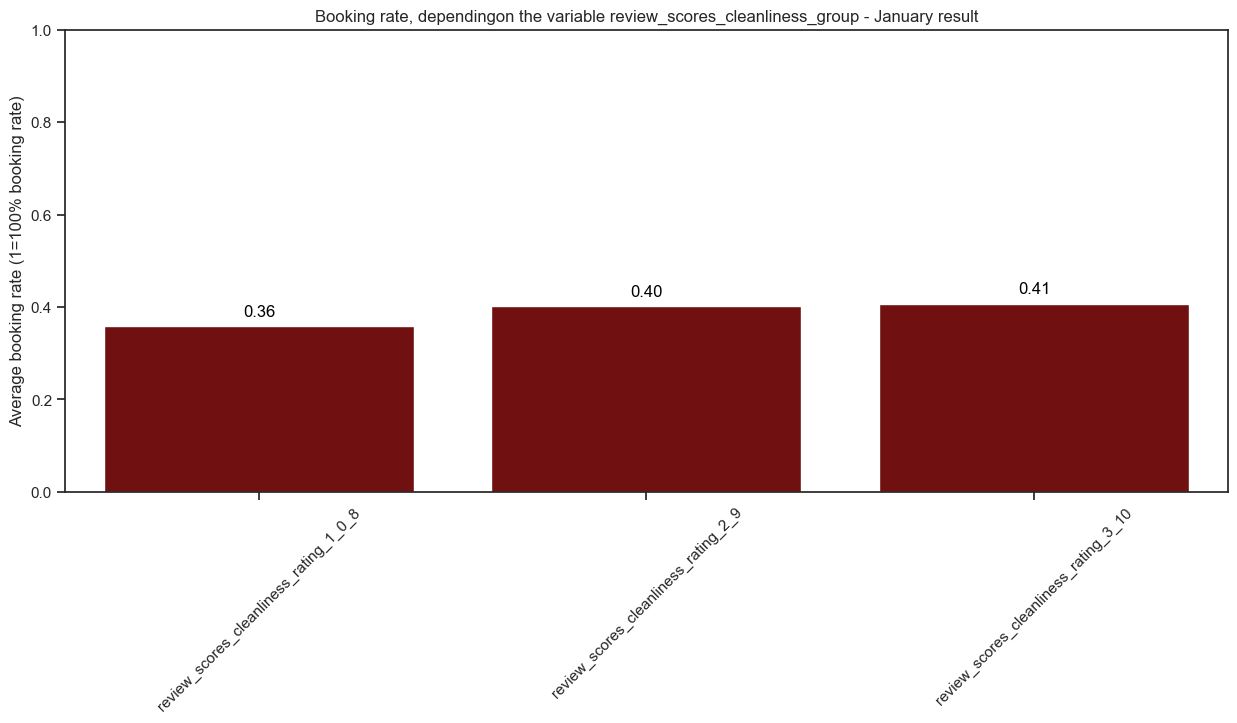

In [216]:
# A bar plot which shows the booking rate with in a category variable
plot_average_rate_jan(df_airbnb_reduced_jan, 'review_scores_cleanliness_group', 'listing_booked', color='maroon')

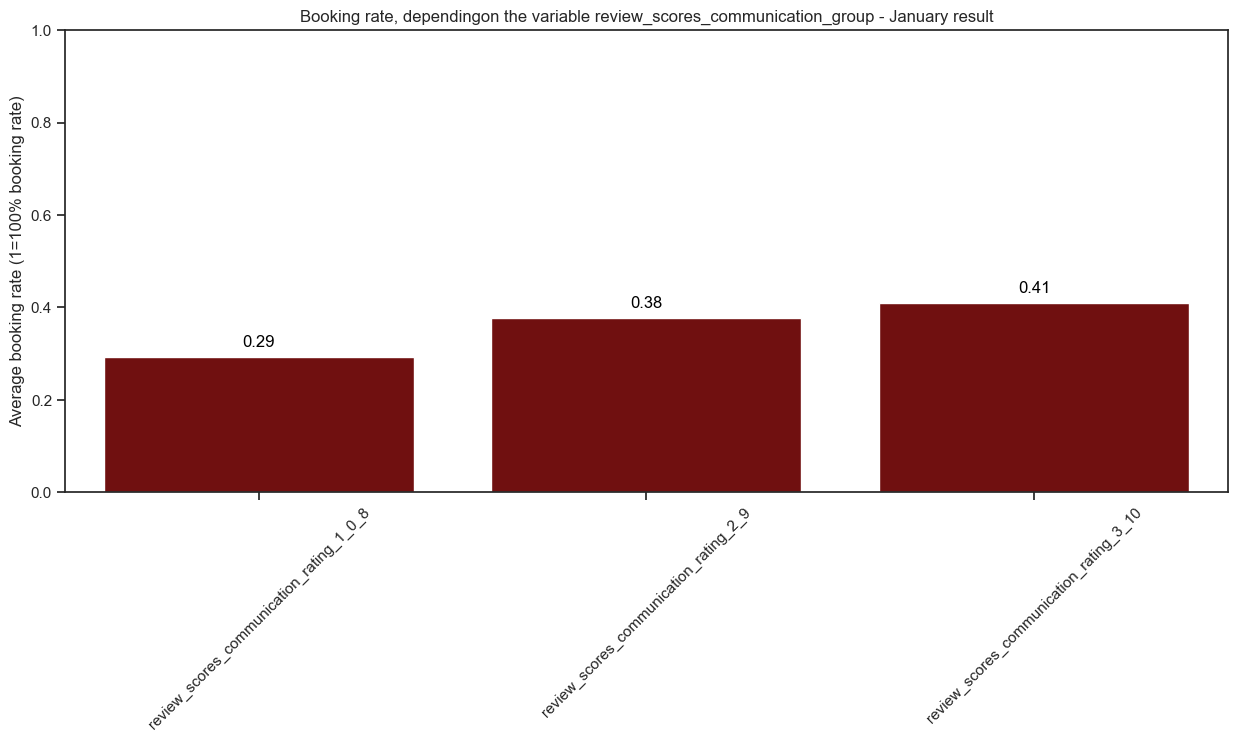

In [214]:
# A bar plot which shows the booking rate with in a category variable
plot_average_rate_jan(df_airbnb_reduced_jan, 'review_scores_communication_group', 'listing_booked', color='maroon')

#### Do the customers premium high response rates?

In [225]:
df_airbnb_reduced_jan.drop_duplicates(subset='listing_id')['host_response_rate_cat'].value_counts()/df_airbnb_reduced_jan.drop_duplicates(subset='listing_id').shape[0]

host_response_rate_cat
host_response_rate_100     0.726467
host_response_rate_0_89    0.142676
host_response_rate_90+     0.083580
host_response_rate_95+     0.047277
Name: count, dtype: float64

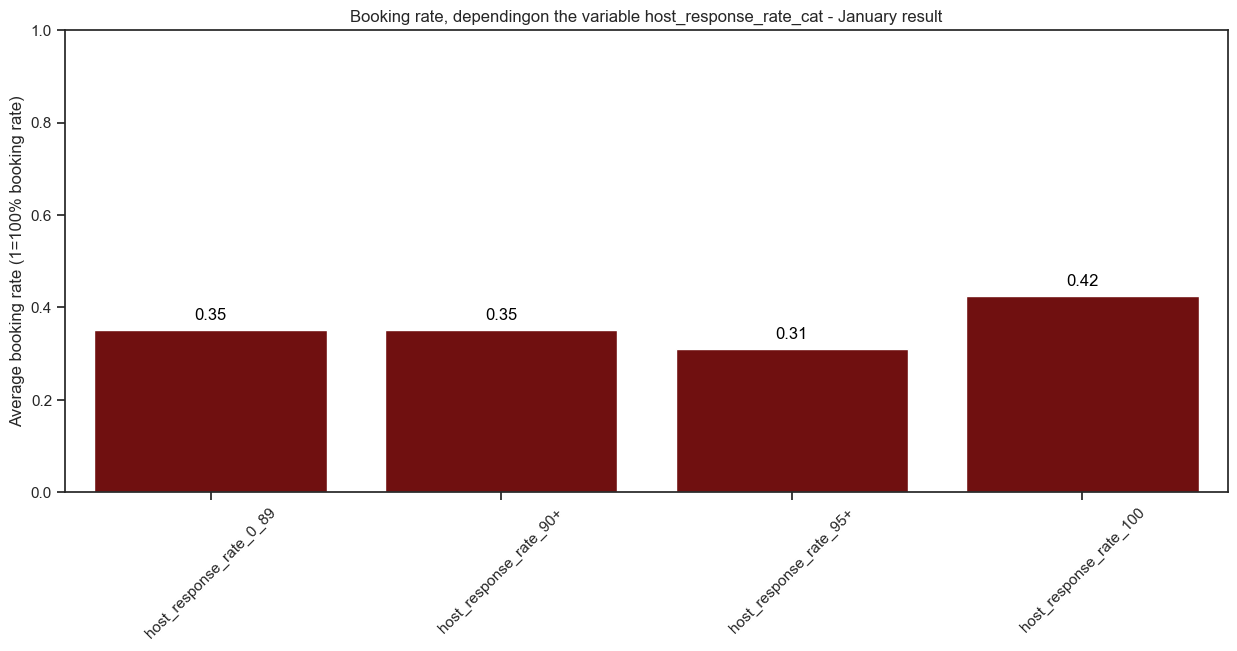

In [223]:
# A bar plot which shows the booking rate with in a category variable
plot_average_rate_jan(df_airbnb_reduced_jan, 'host_response_rate_cat', 'listing_booked', color='maroon')

#### Do a more comprehensive text description of the listing affect demand?

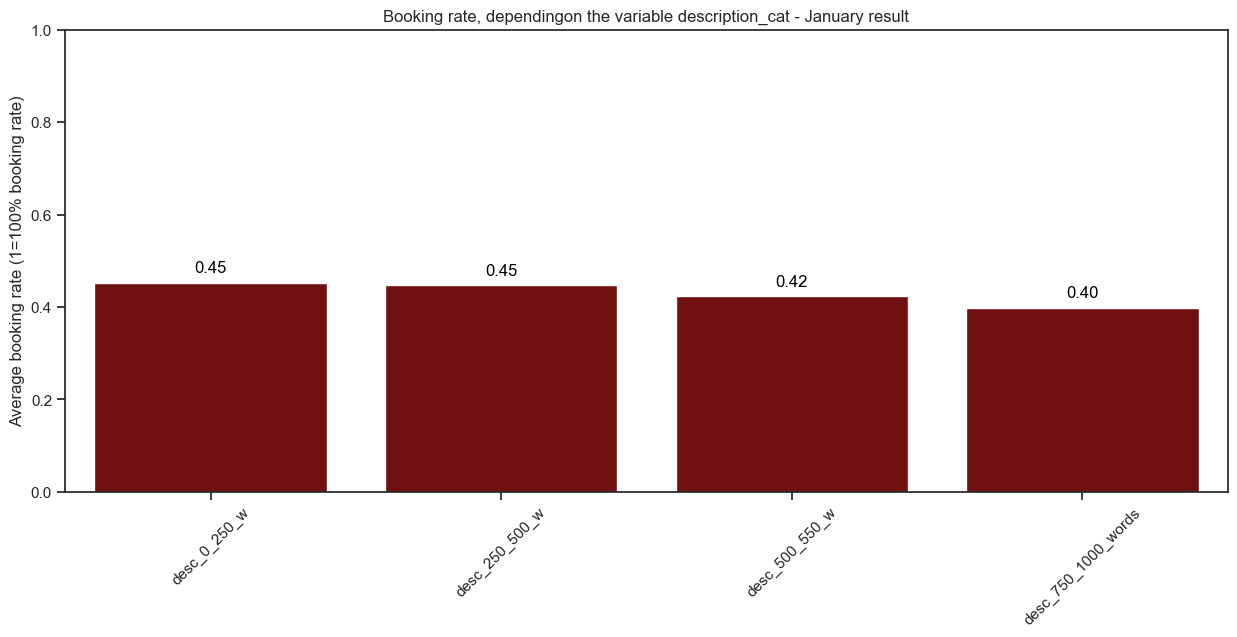

In [233]:
# A bar plot which shows the booking rate with in a category variable
plot_average_rate_jan(df_airbnb_reduced_jan, 'description_cat', 'listing_booked', color='maroon')

#### Is it worth the effort to focus on a long personal description?

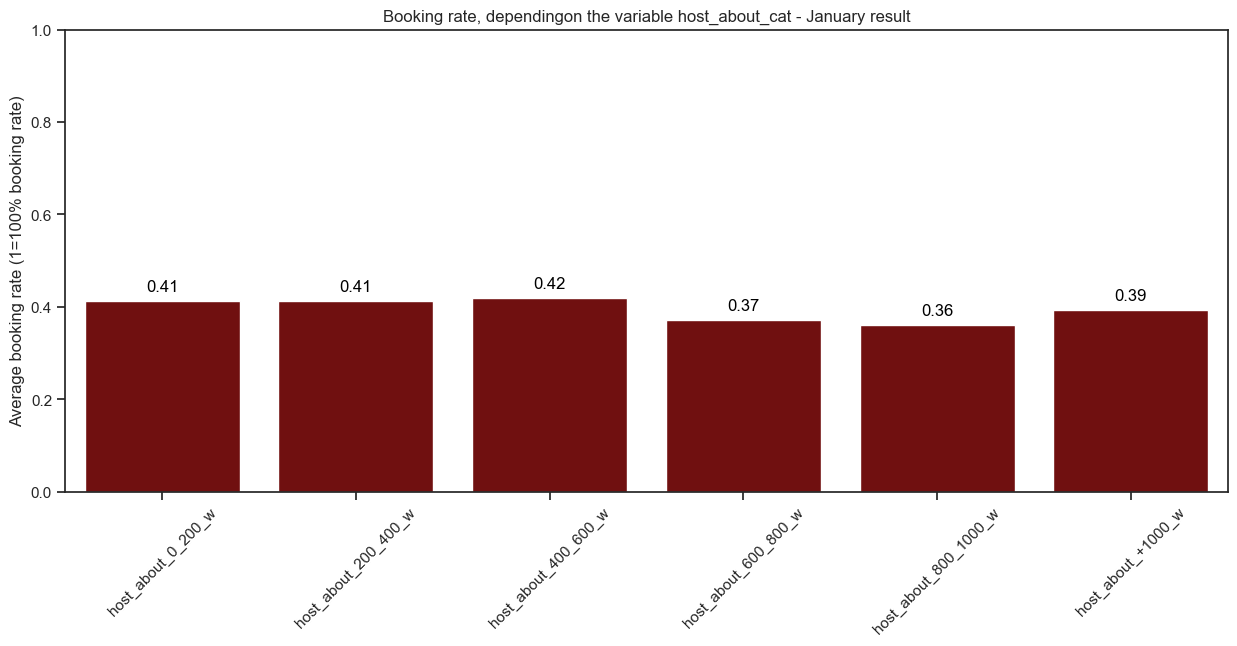

In [234]:
# Filter out rows where host_about_cat equals "host_about__missing"
filtered_df = df_airbnb_reduced_jan[df_airbnb_reduced_jan['host_about_cat'] != "host_about__missing"]

# 'host_about__missing' will still be present on the x-axis, why we need to drop this manually
filtered_df['host_about_cat'] = filtered_df['host_about_cat'].cat.remove_categories("host_about__missing")

# Plot the result
plot_average_rate_jan(filtered_df, 'host_about_cat', 'listing_booked', color='maroon')